# Imports

In [1]:
import os
import sys
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from decimal import Decimal
from kerasAC.splits import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

sys.path.insert(0, "/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm")
from viz_preprocess import *
from viz_sequence import *

np.random.seed(1234)
plt.style.use('default')
pd.set_option('display.max_columns', None)

TF-MoDISco is using the TensorFlow backend.
Using TensorFlow backend.


# Quick Links

<ol>
    <li><a href=#effect_table>Effect Alleles Table</a></li>
    <li><a href=#effect_viz>Effect Alleles Visual</a></li>
    <li><a href=#noneffect_table>Non-Effect Alleles Table</a></li>
    <li><a href=#noneffect_viz>Non-Effect Alleles Visual</a></li>
</ol>

# Cluster 23

In [2]:
cluster = '23'

## Prepare Effect and Non-Effect Scores

In [3]:
effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.effect.fasta'
effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

print("Num effect sequences:", len(effect_onehot))

merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

for fold in range(10):
    effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.effect.scores.txt'
    effect_scores = get_hyp_scores(effect_file, effect_seqs)
    effect_scores = np.array(effect_scores)
    merged_effect_scores = merged_effect_scores + effect_scores
    
merged_effect_scores = merged_effect_scores / (fold + 1)

#--------------------------------------------------------#

noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.noneffect.fasta'
noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

print("Num noneffect sequences:", len(noneffect_onehot))

merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

for fold in range(10):
    noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
    noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
    noneffect_scores = np.array(noneffect_scores)
    merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
    
merged_noneffect_scores = merged_noneffect_scores / (fold + 1)

#--------------------------------------------------------#

merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

for fold in range(10):
    ism_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'+cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
    delta_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'+cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
    merged_ism_scores = merged_ism_scores + ism_scores
    merged_delta_scores = merged_delta_scores + delta_scores
        
merged_ism_scores = merged_ism_scores / (fold + 1)
merged_delta_scores = merged_delta_scores / (fold + 1)

Num effect sequences: 285
Num noneffect sequences: 285


## Prepare DataFrame

In [4]:
snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'+cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
ryan_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/191023_All_GWAS_SNPs_unique.csv', sep='\t')
mike_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/ld_buddies_table_stage3.tsv', sep='\t')
effect_score = []
noneffect_score = []
effect_center = []
noneffect_center = []
effect_ratio = []
noneffect_ratio = []
allele_ratio = []
allele_diff = []
effect_rank = []
noneffect_rank = []
ism_score = []
delta_score = []
idr_peak = []
all_gwas = []
coloc = []
for index,row in snps.iterrows():
    effect_score.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][400:600]])))
    noneffect_score.append(np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][400:600]])))
    effect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])))
    noneffect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])))
    effect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][400:600]])))
    noneffect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][400:600]])))
    allele_ratio.append(effect_center[-1] / (noneffect_center[-1] + 0.00001))
    #allele_diff.append(effect_center[-1] - noneffect_center[-1])
    allele_diff.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][475:525]])) - np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][475:525]])))
    effect_rank.append((effect_center[-1] / (noneffect_center[-1] + 0.00001)) * effect_ratio[-1])
    noneffect_rank.append((noneffect_center[-1] / (effect_center[-1] + 0.00001)) * noneffect_ratio[-1])
    idr_peak_overlap = False
    for ind,rw in ryan_snps.loc[ryan_snps['rsid']==row['rsid']].iterrows():
        if rw['Cluster'+cluster+'_overlap'] == 1:
            idr_peak_overlap = True
    idr_peak.append(idr_peak_overlap)
    gwas_list = []
    has_coloc = False
    for ind,rw in mike_snps.loc[mike_snps['rsid']==row['rsid']].iterrows():
        gwas_list.append(rw['source_gwas']+': '+str('%.2E' % Decimal(rw['pvalue'])))
        if rw['has_coloc'] == True:
            has_coloc = True
    all_gwas.append(gwas_list)
    coloc.append(has_coloc)
snps['effect_score'] = effect_score
snps['noneffect_score'] = noneffect_score
snps['effect_center'] = effect_center
snps['noneffect_center'] = noneffect_center
snps['effect_ratio'] = effect_ratio
snps['noneffect_ratio'] = noneffect_ratio
snps['allele_ratio'] = allele_ratio
snps['allele_diff'] = allele_diff
snps['effect_rank'] = effect_rank
snps['noneffect_rank'] = noneffect_rank
snps['ism_score'] = merged_ism_scores
snps['delta_score'] = merged_delta_scores
snps['idr_peak'] = idr_peak
snps['all_gwas'] = all_gwas
snps['coloc'] = coloc
snps.sort_values(by=['allele_ratio'], ascending=True, inplace=True)
snps.drop_duplicates(subset=['rsid'], inplace=True)

## Find Effect Alleles that Break Accessibility <a name='effect_table' />

In [5]:
neg_snps = snps.loc[snps['allele_ratio'] <= 1]
neg_snps.sort_values(by=['noneffect_rank'], ascending=False, inplace=True)
display(neg_snps)

chr      start        end         rsid effect noneffect    ref  \
260   chr4   89836583   89836584    rs2619361      C         A      C   
220   chr3  151383957  151383958   rs12485508      T         C      C   
270   chr6   27772520   27772521     rs760587      C         A      C   
261   chr4   89837895   89837896    rs2619363    NAN       NAN      G   
243   chr4   89829436   89829437    rs2583979      T         A      A   
206   chr3   49007333   49007334    rs6781790      T         C      C   
53   chr16   31117293   31117294    rs4889619      T         C      C   
145  chr19   18462023   18462024    rs8103622      T         C      C   
252   chr4   89830263   89830264     rs986609      G         C      C   
266   chr5  103120549  103120550      rs26523      T         C      C   
94   chr17   45914521   45914522   rs55682376      G         A      G   
91   chr17   45895214   45895215   rs74457229      T         C      C   
88   chr17   45894418   45894419   rs11575895      G         A      A   
31   chr12   41477001   41477002  rs187043470      C         A      A   
182   chr2  101736882  101736883    rs7569049      T         G      T   
62   chr17    5306214    5306215  rs199819792      A         C  AACAG   
191   chr2  127107345  127107346   rs78710909    NAN       NAN      G   
90   chr17   45894775   45894776   rs11575896      G         A      G   
93   chr17   45914204   45914205  rs141801658      I         D      G   
116  chr17   46143983   46143984    rs2532307      A         G      G   
269   chr5  134587210  134587211   rs17167630      T         C      T   
69   chr17   45825494   45825495   rs34283254      C         A      C   
215   chr3   52557247   52557248  rs151215721      G         A      G   
24   chr11   86103987   86103988    rs1237999      A         G      G   
134  chr17   78426790   78426791   rs72914885      C         A      A   
188   chr2  127107344  127107345   rs76516995      C         G      C   
164  chr19   44954977   44954978   rs41334244      G         A      A   
236   chr4   89709662   89709663     rs356175      T         C      C   
179   chr2   95076932   95076933    rs3105101      C         A      C   
268   chr5  103224668  103224669     rs246913      G         C      G   
..     ...        ...        ...          ...    ...       ...    ...   
160  chr19   44954888   44954889    rs3760629      A         C      A   
263   chr5   60903373   60903374    rs1038144      T         C      C   
283   chr8   27610985   27610986     rs867230      C         A      C   
118  chr17   46192597   46192598   rs11079733      T         A      T   
267   chr5  103120599  103120600      rs26524      G         A      A   
249   chr4   89829692   89829693    rs2619356      T         C      C   
195   chr2  127118665  127118666   rs71414738      T         C      C   
26   chr11   86145144   86145145    rs7110631      C         G      C   
192   chr2  127107523  127107524   rs13032148      A         G      G   
18   chr11   65834088   65834089   rs17854357      C         G      G   
170  chr19   44989300   44989301   rs11669173      G         A      G   
106  chr17   46002672   46002673   rs62064663      T         G      T   
28   chr12   40105791   40105792  rs139518863      T         C      C   
58   chr17    4909107    4909108   rs16954243      A         T      A   
174  chr19   45045876   45045877  rs112481437      A         G      G   
1     chr1  171742011  171742012   rs12119232      C         A      A   
87   chr17   45894237   45894238   rs62056778      G         C      C   
198   chr2  168247488  168247489   rs76179989      T         G      T   
84   chr17   45849625   45849626   rs56269136      T         C      C   
101  chr17   45949128   45949129   rs74531363      G         A      A   
264   chr5  103041308  103041309    rs6881612      T         C      C   
219   chr3  151383902  151383903   rs10935841      T         C      C   
193   chr2  127107527  127107528  2_127107528    NAN       NAN   

## Visualize Top Effect Alleles <a name='effect_viz' />

RSID: rs2619361   ||    chr4 : 89836583 - 89836584   ||    Locus: 260   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  2.97E-07
23andme_PD_hg38 		  1.36E-08

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.2303   ||   Center / 200bp : 0.2798
Noneffect Sequence : GTCTCTTTCATTAGGCTCCC


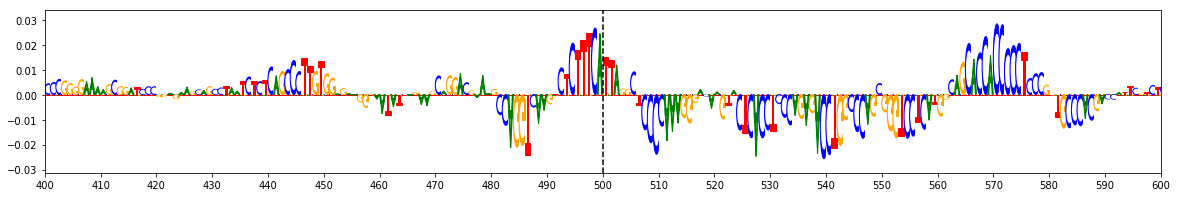

Effect Allele : C   ||   Explain Score : 0.0351   ||   Center / 200bp : 0.0558
Effect Sequence : GTCTCTTTCCTTAGGCTCCC


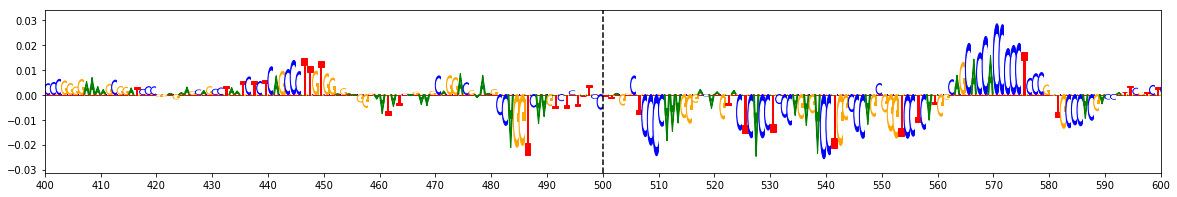

Allele Ratio : 0.1523   ||   Allele Difference : -0.2381  ||  ISM Score : -0.3721  ||  deltaSVM Score : -2.1523


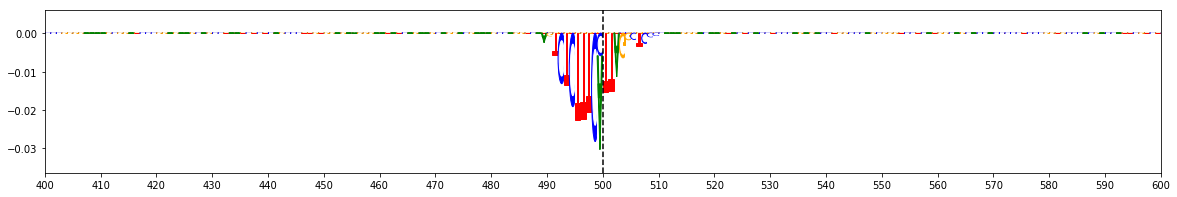


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs12485508   ||    chr3 : 151383957 - 151383958   ||    Locus: 220   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  2.28E-05

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.2518   ||   Center / 200bp : 0.428
Noneffect Sequence : TACTGATGGCGATTTCTGCC


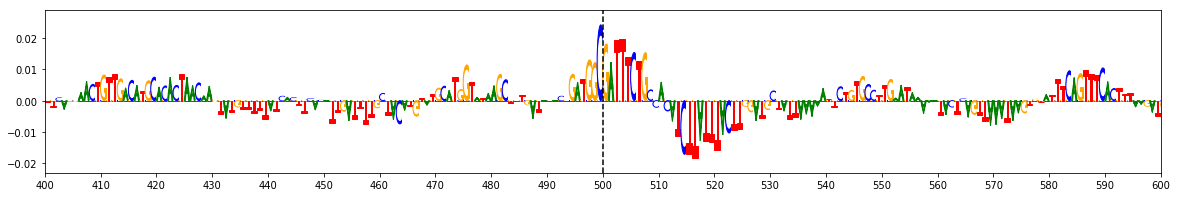

Effect Allele : T   ||   Explain Score : 0.0615   ||   Center / 200bp : 0.1545
Effect Sequence : TACTGATGGTGATTTCTGCC


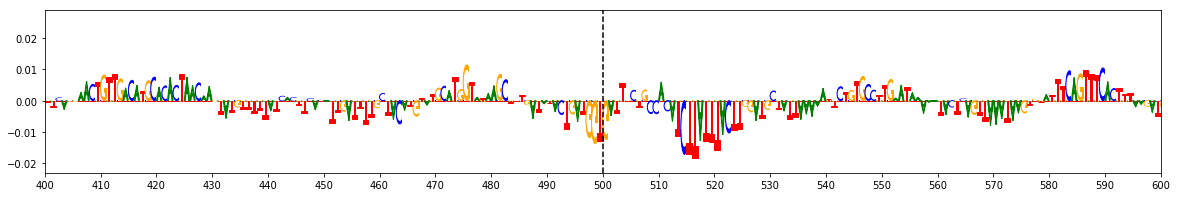

Allele Ratio : 0.2442   ||   Allele Difference : -0.2921  ||  ISM Score : -0.4587  ||  deltaSVM Score : -2.6459


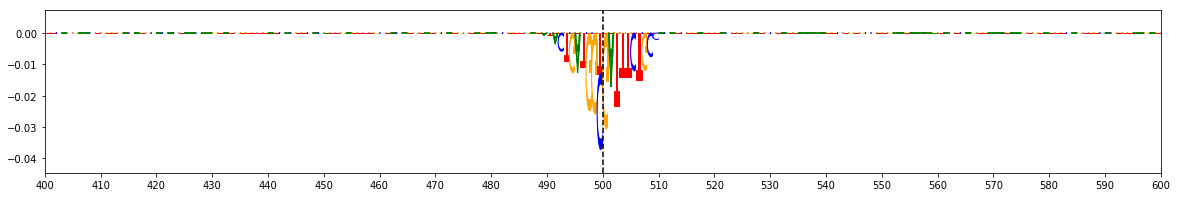


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs760587   ||    chr6 : 27772520 - 27772521   ||    Locus: 270   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  6.44E-06

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 0.997   ||   Center / 200bp : 0.5466
Noneffect Sequence : GAGCAGCAAACAAAGGCTAA


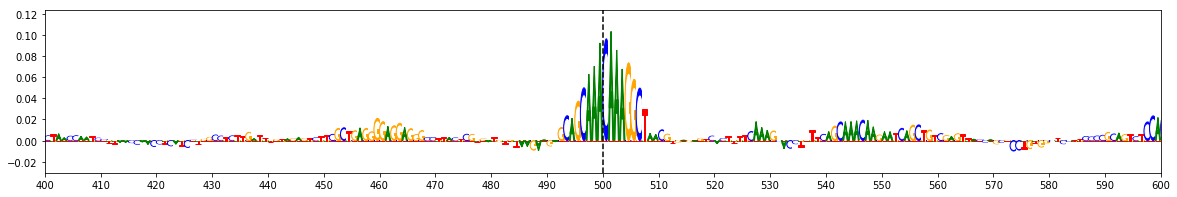

Effect Allele : C   ||   Explain Score : 0.4341   ||   Center / 200bp : 0.3433
Effect Sequence : GAGCAGCAACCAAAGGCTAA


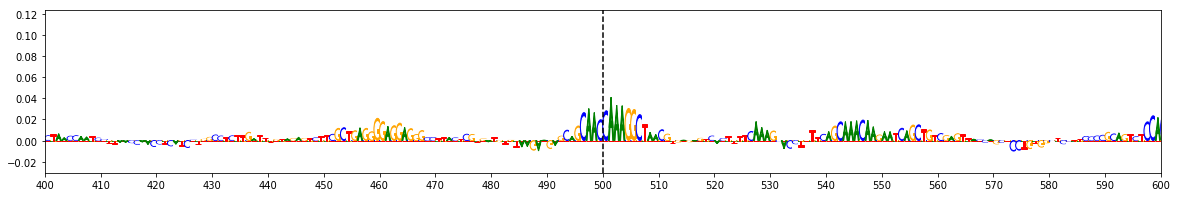

Allele Ratio : 0.4354   ||   Allele Difference : -0.5692  ||  ISM Score : -0.8927  ||  deltaSVM Score : -5.0981


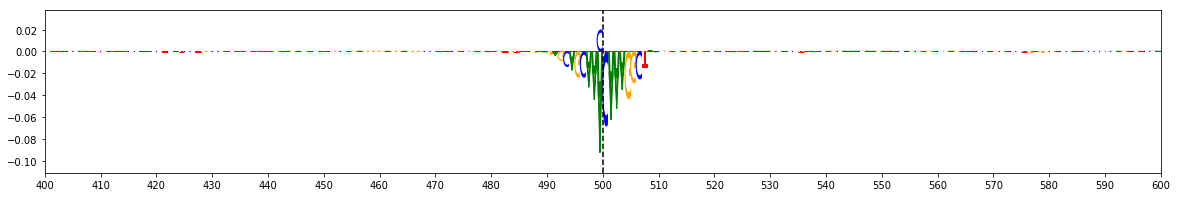


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2619363   ||    chr4 : 89837895 - 89837896   ||    Locus: 261   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  NAN
23andme_PD_hg38 		  1.43E-08

Coloc:  True

Noneffect Allele : NAN   ||   Explain Score : 1.1745   ||   Center / 200bp : 0.6274
Noneffect Sequence : CCAATCAGCGCCTGCCAGAC


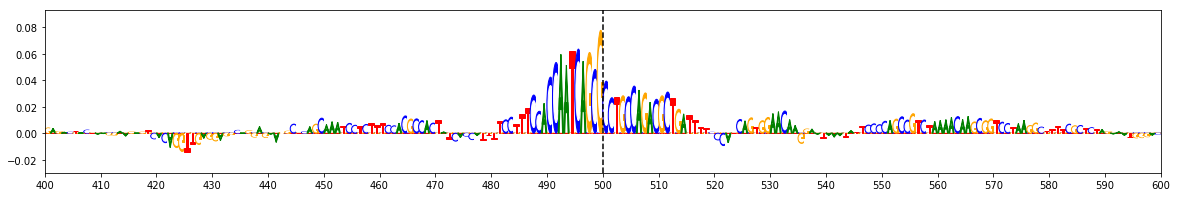

Effect Allele : NAN   ||   Explain Score : 0.627   ||   Center / 200bp : 0.4715
Effect Sequence : CCAATCAGCCCCTGCCAGAC


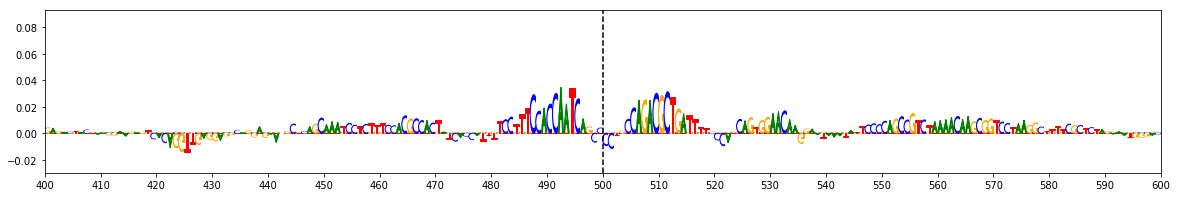

Allele Ratio : 0.5339   ||   Allele Difference : -0.5772  ||  ISM Score : -0.8761  ||  deltaSVM Score : -5.2874


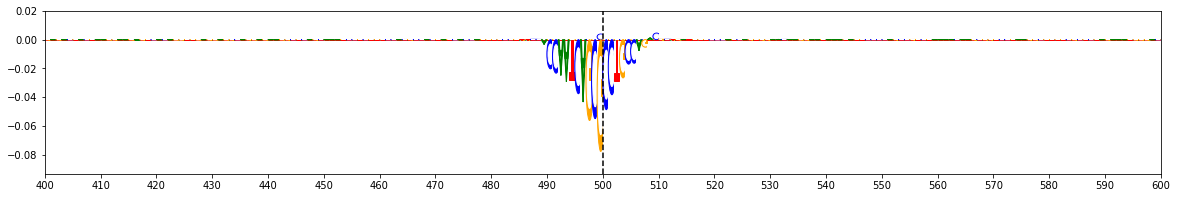


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2583979   ||    chr4 : 89829436 - 89829437   ||    Locus: 243   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  NAN
23andme_PD_hg38 		  3.63E-14

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.4034   ||   Center / 200bp : 0.5417
Noneffect Sequence : TTTTCAGCAACACTTCCTCT


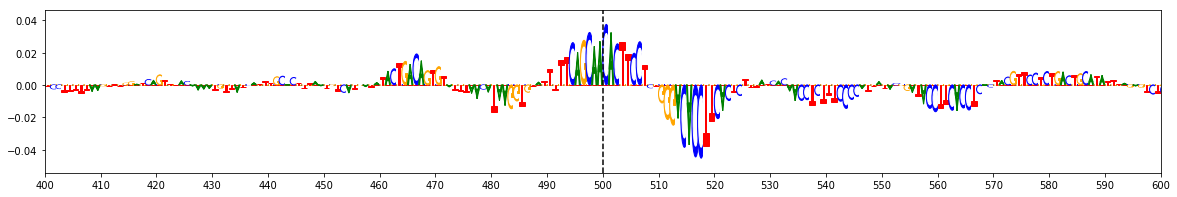

Effect Allele : T   ||   Explain Score : 0.1977   ||   Center / 200bp : 0.3672
Effect Sequence : TTTTCAGCATCACTTCCTCT


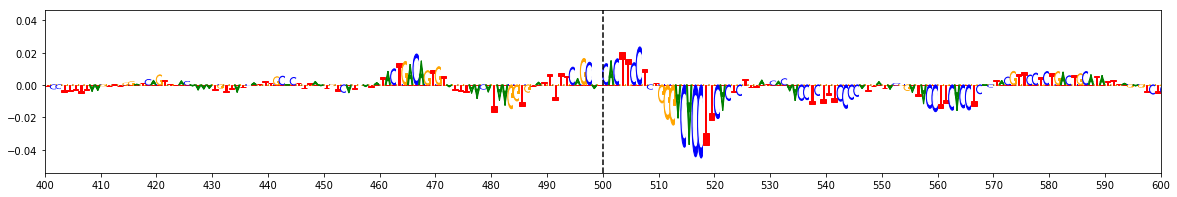

Allele Ratio : 0.49   ||   Allele Difference : -0.2132  ||  ISM Score : -0.3363  ||  deltaSVM Score : -1.9407


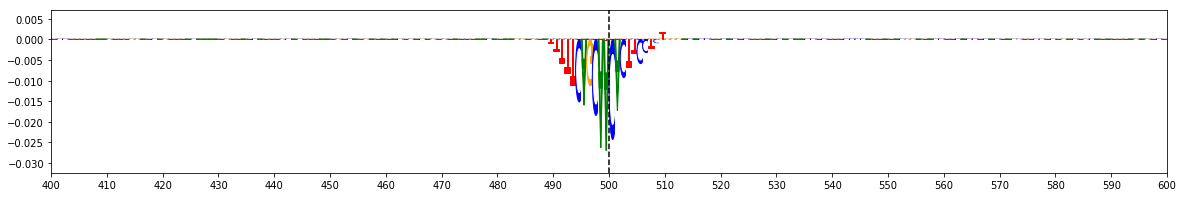


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs6781790   ||    chr3 : 49007333 - 49007334   ||    Locus: 206   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  2.35E-03
Nalls_23andMe 		  2.35E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.8734   ||   Center / 200bp : 0.3998
Noneffect Sequence : AGCTGAGGGCGCTGTTGATG


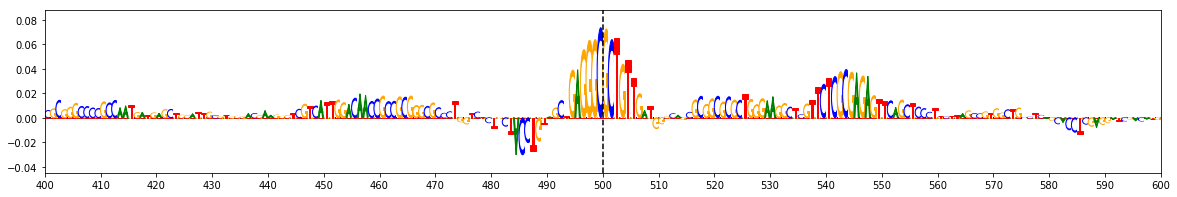

Effect Allele : T   ||   Explain Score : 0.3383   ||   Center / 200bp : 0.2049
Effect Sequence : AGCTGAGGGTGCTGTTGATG


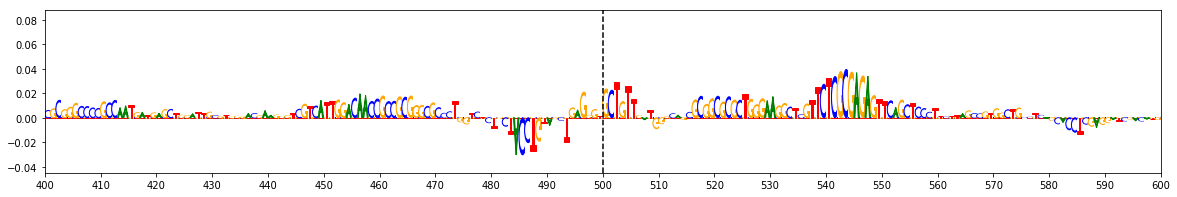

Allele Ratio : 0.3873   ||   Allele Difference : -0.5651  ||  ISM Score : -0.8898  ||  deltaSVM Score : -5.1499


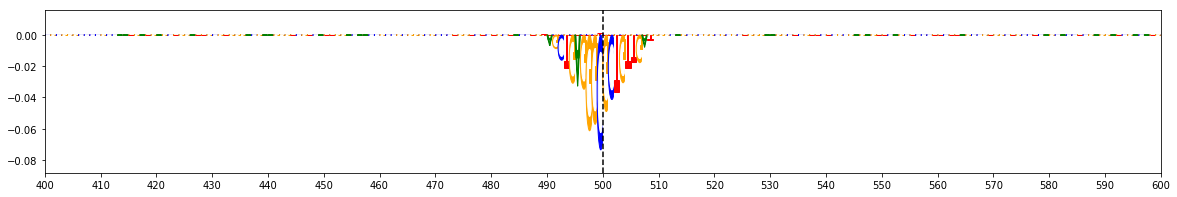


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs4889619   ||    chr16 : 31117293 - 31117294   ||    Locus: 53   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  3.40E-02

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.3343   ||   Center / 200bp : 0.413
Noneffect Sequence : GCTTGAACCCGGAGGCGGAG


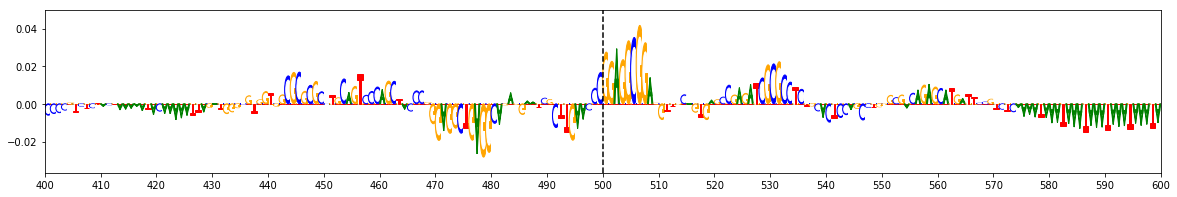

Effect Allele : T   ||   Explain Score : 0.1374   ||   Center / 200bp : 0.2241
Effect Sequence : GCTTGAACCTGGAGGCGGAG


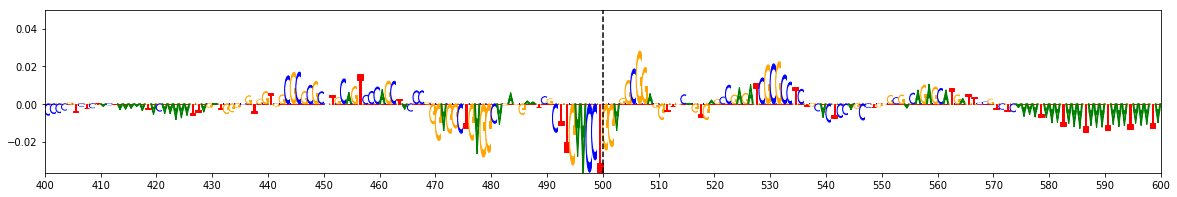

Allele Ratio : 0.4109   ||   Allele Difference : -0.4385  ||  ISM Score : -0.7393  ||  deltaSVM Score : -4.2372


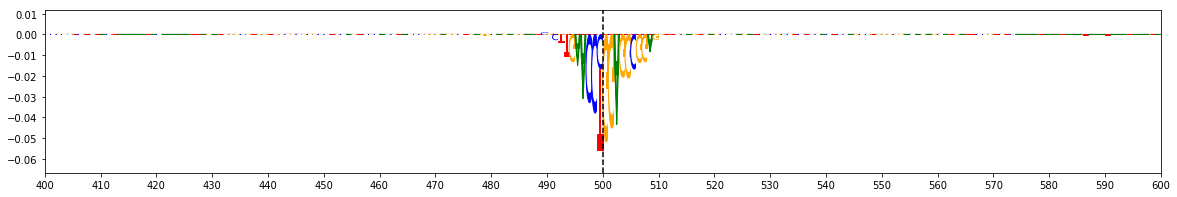


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs8103622   ||    chr19 : 18462023 - 18462024   ||    Locus: 145   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  7.31E-02
Alzheimers_Kunkle_2019 		  1.28E-05
Alzheimers_Lambert_2013 	  3.29E-05

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 1.6191   ||   Center / 200bp : 0.7267
Noneffect Sequence : GACCAAGAGCGCCACCTGCT


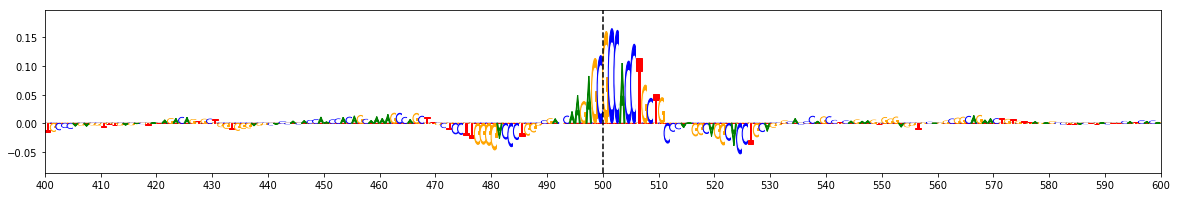

Effect Allele : T   ||   Explain Score : 1.2572   ||   Center / 200bp : 0.6739
Effect Sequence : GACCAAGAGTGCCACCTGCT


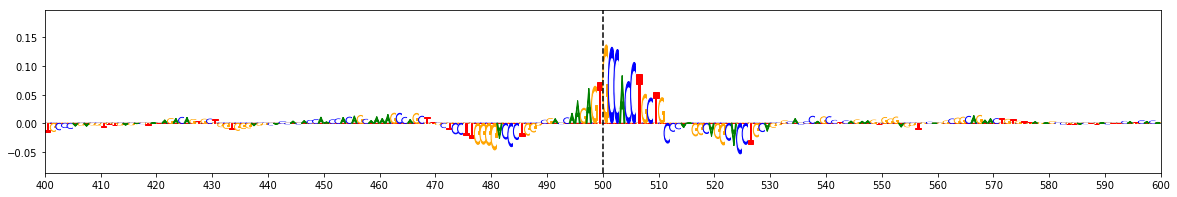

Allele Ratio : 0.7765   ||   Allele Difference : -0.3619  ||  ISM Score : -0.5949  ||  deltaSVM Score : -3.3944


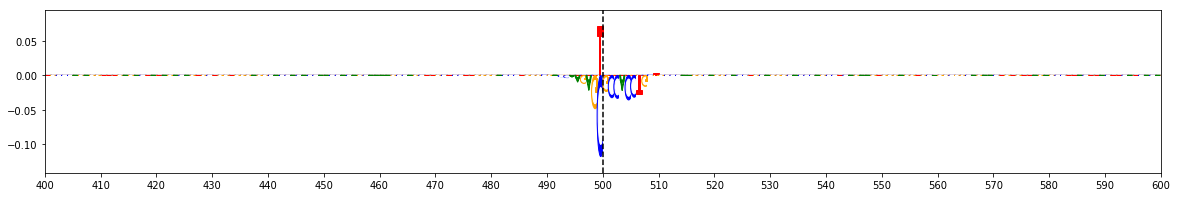


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs986609   ||    chr4 : 89830263 - 89830264   ||    Locus: 252   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  1.97E-07
23andme_PD_hg38 		  1.07E-08

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.4774   ||   Center / 200bp : 0.6085
Noneffect Sequence : GGCTGACAACGGTAAGAGGG


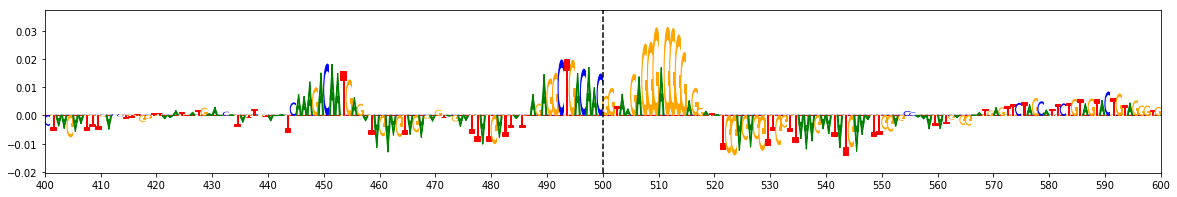

Effect Allele : G   ||   Explain Score : 0.3452   ||   Center / 200bp : 0.5292
Effect Sequence : GGCTGACAAGGGTAAGAGGG


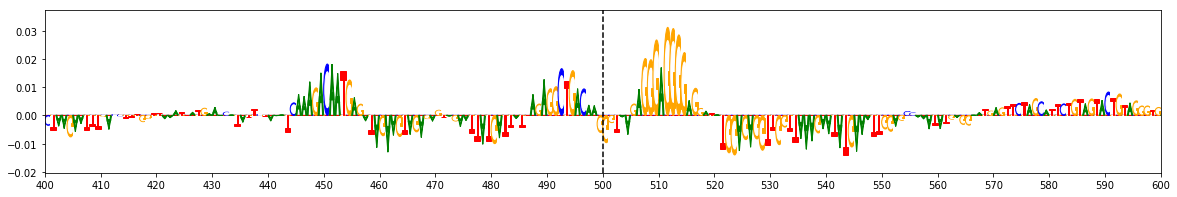

Allele Ratio : 0.7232   ||   Allele Difference : -0.1639  ||  ISM Score : -0.2562  ||  deltaSVM Score : -1.4804


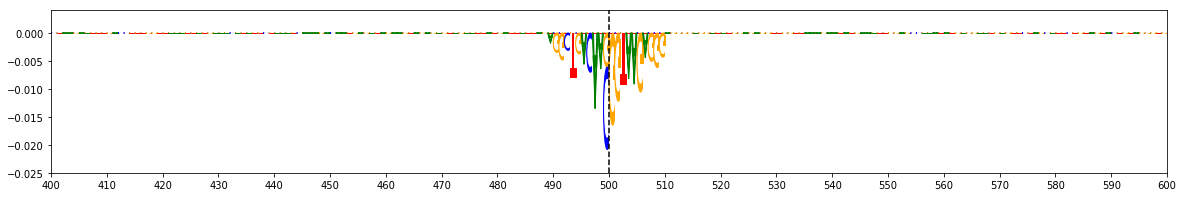


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs26523   ||    chr5 : 103120549 - 103120550   ||    Locus: 266   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.08E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.5069   ||   Center / 200bp : 0.4507
Noneffect Sequence : GGGTTGAGGCGGCTGCTGGG


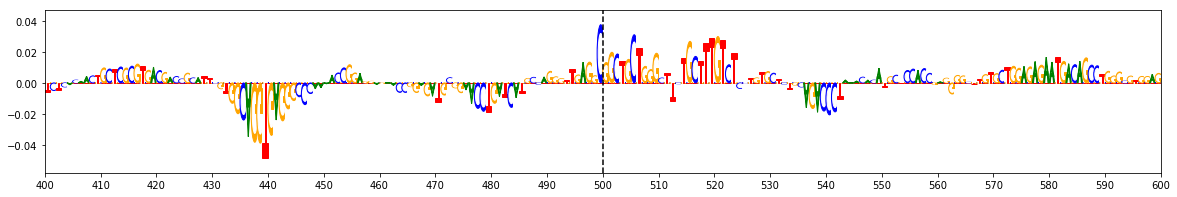

Effect Allele : T   ||   Explain Score : 0.2794   ||   Center / 200bp : 0.3116
Effect Sequence : GGGTTGAGGTGGCTGCTGGG


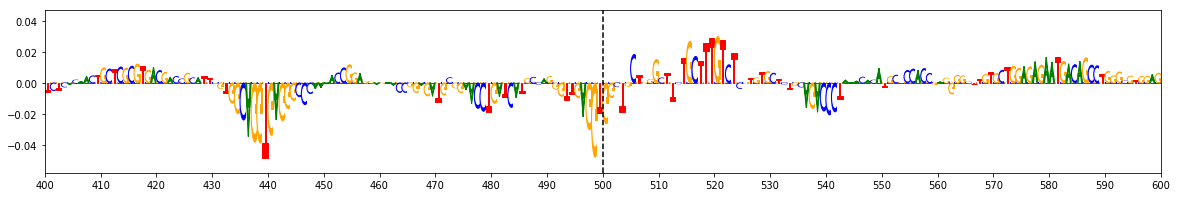

Allele Ratio : 0.5512   ||   Allele Difference : -0.4448  ||  ISM Score : -0.6955  ||  deltaSVM Score : -4.0047


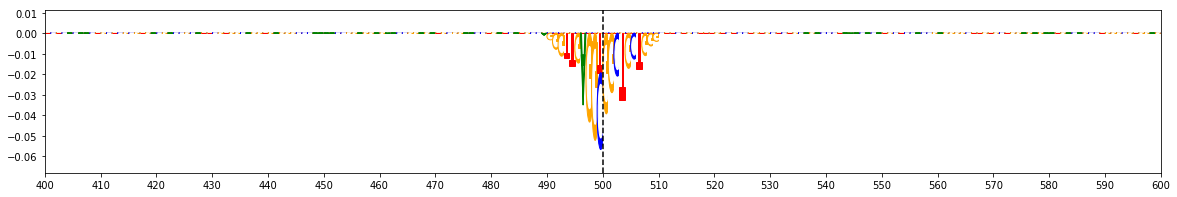


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs55682376   ||    chr17 : 45914521 - 45914522   ||    Locus: 94   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.96E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.8934   ||   Center / 200bp : 0.6239
Noneffect Sequence : ACAAGGCAGATACTGTGTAC


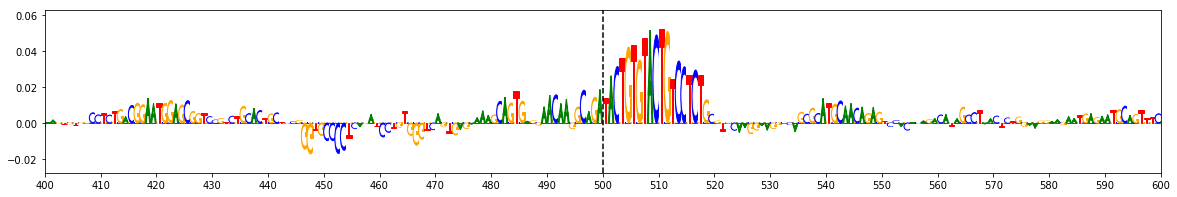

Effect Allele : G   ||   Explain Score : 0.7038   ||   Center / 200bp : 0.5659
Effect Sequence : ACAAGGCAGGTACTGTGTAC


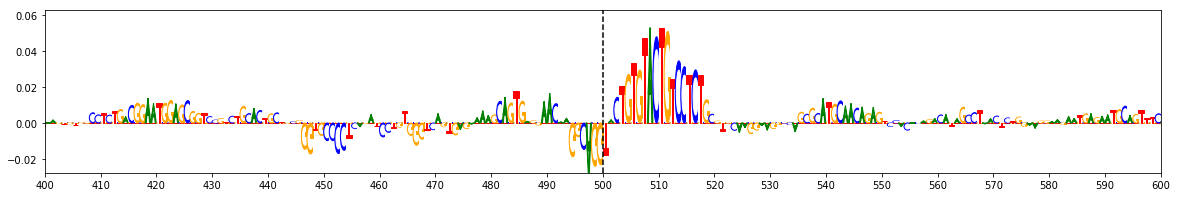

Allele Ratio : 0.7878   ||   Allele Difference : -0.3272  ||  ISM Score : -0.5154  ||  deltaSVM Score : -2.9456


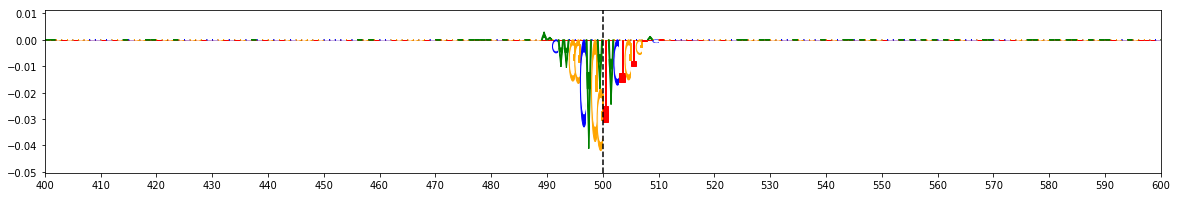


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs74457229   ||    chr17 : 45895214 - 45895215   ||    Locus: 91   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.3111   ||   Center / 200bp : 0.5232
Noneffect Sequence : ACGCCCCTCCCTGCACCTCC


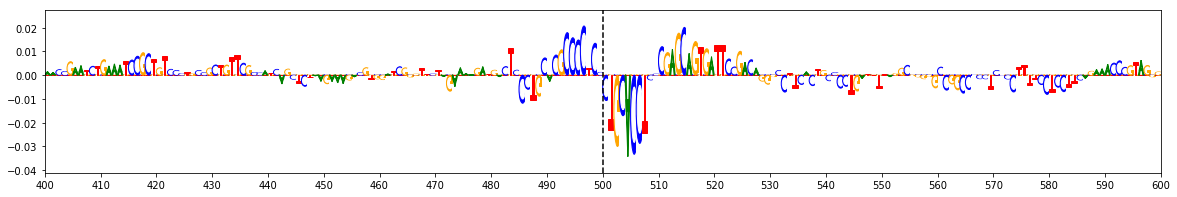

Effect Allele : T   ||   Explain Score : 0.2075   ||   Center / 200bp : 0.4207
Effect Sequence : ACGCCCCTCTCTGCACCTCC


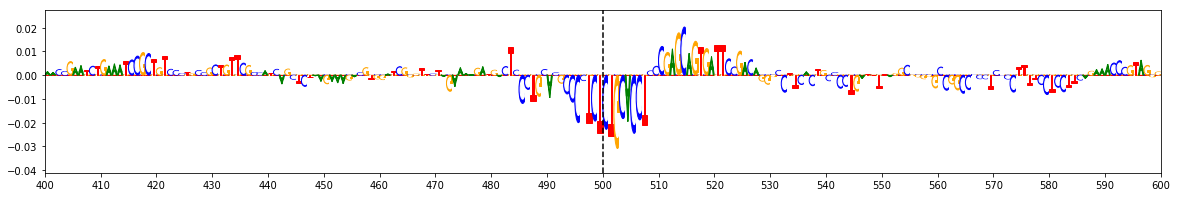

Allele Ratio : 0.6669   ||   Allele Difference : -0.1978  ||  ISM Score : -0.333  ||  deltaSVM Score : -1.9658


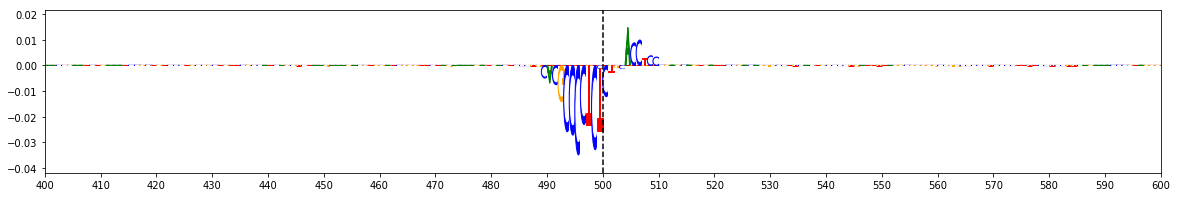


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11575895   ||    chr17 : 45894418 - 45894419   ||    Locus: 88   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 2.3347   ||   Center / 200bp : 0.6888
Noneffect Sequence : GCGCCCACTAGTGGCCGGAG


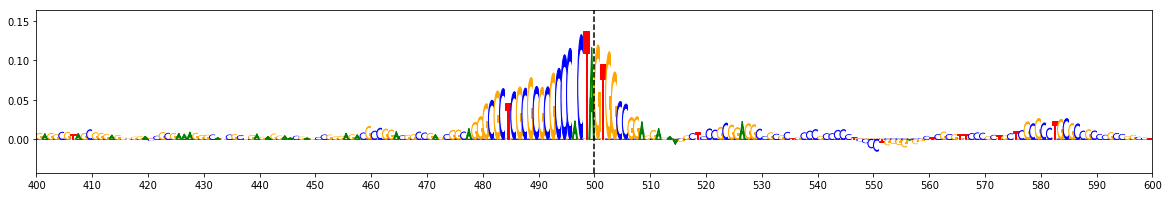

Effect Allele : G   ||   Explain Score : 2.0525   ||   Center / 200bp : 0.6584
Effect Sequence : GCGCCCACTGGTGGCCGGAG


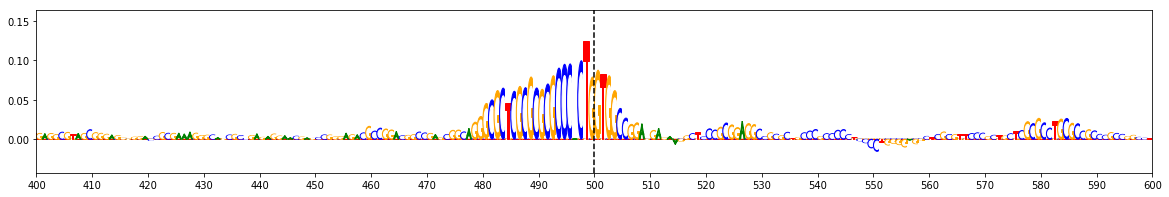

Allele Ratio : 0.8791   ||   Allele Difference : -0.2825  ||  ISM Score : -0.4025  ||  deltaSVM Score : -2.8743


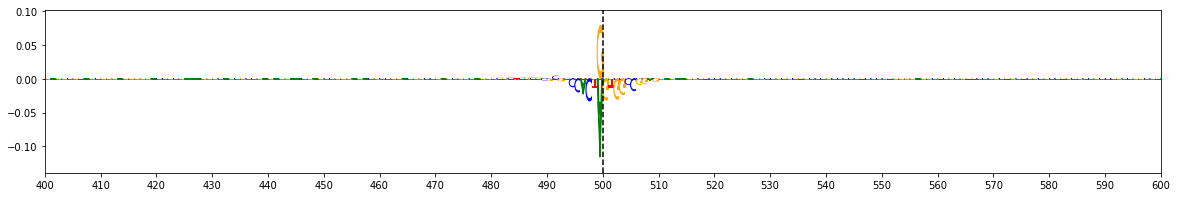


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs187043470   ||    chr12 : 41477001 - 41477002   ||    Locus: 31   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.92E-18

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 0.4878   ||   Center / 200bp : 0.4344
Noneffect Sequence : TGAATATACAAAAGTCATTT


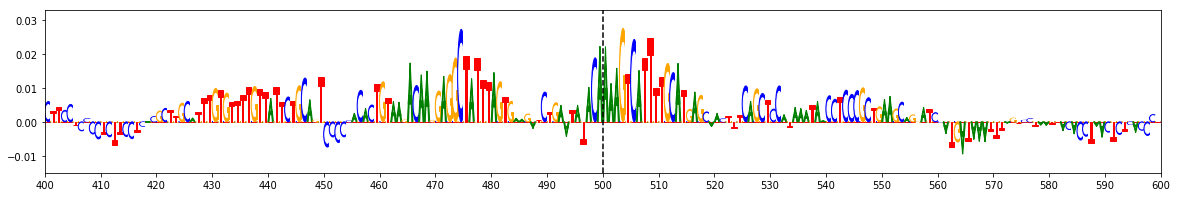

Effect Allele : C   ||   Explain Score : 0.2705   ||   Center / 200bp : 0.2987
Effect Sequence : TGAATATACCAAAGTCATTT


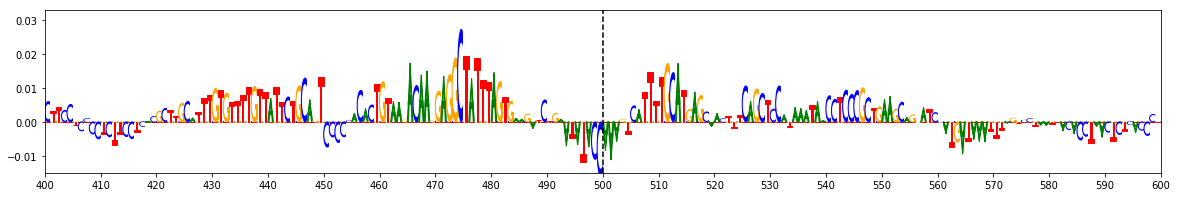

Allele Ratio : 0.5545   ||   Allele Difference : -0.3006  ||  ISM Score : -0.469  ||  deltaSVM Score : -2.6929


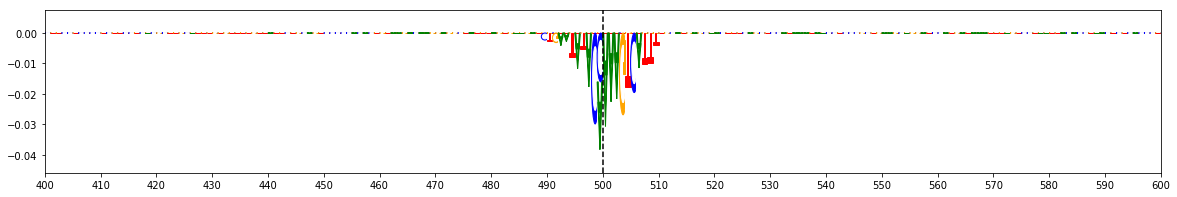


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7569049   ||    chr2 : 101736882 - 101736883   ||    Locus: 182   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.65E-03
Chang_23andMe_Parkinsons 	  1.65E-03

Coloc:  False

Noneffect Allele : G   ||   Explain Score : 0.5593   ||   Center / 200bp : 0.5349
Noneffect Sequence : TAAAGCAGTGAAAGCCCTGG


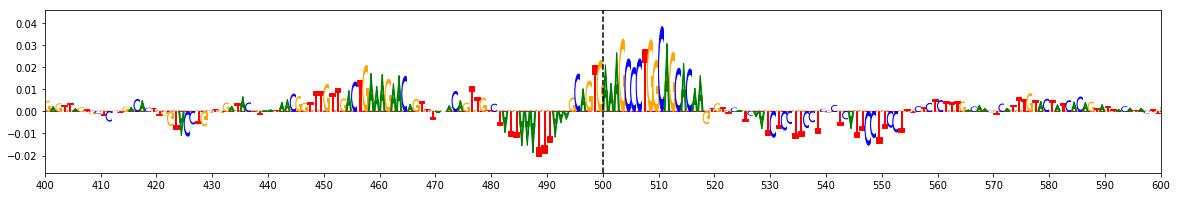

Effect Allele : T   ||   Explain Score : 0.3847   ||   Center / 200bp : 0.4416
Effect Sequence : TAAAGCAGTTAAAGCCCTGG


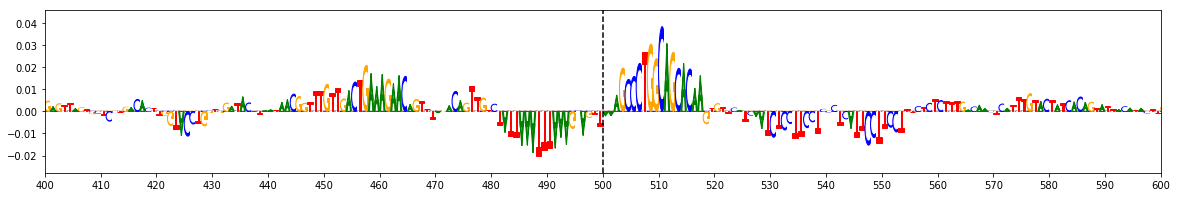

Allele Ratio : 0.6878   ||   Allele Difference : -0.2324  ||  ISM Score : -0.3622  ||  deltaSVM Score : -2.0983


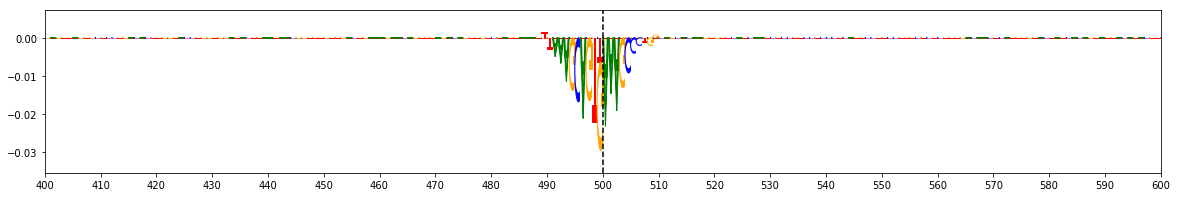


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs199819792   ||    chr17 : 5306214 - 5306215   ||    Locus: 62   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  9.03E-08

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 2.0532   ||   Center / 200bp : 0.726
Noneffect Sequence : ATCTTCTAACAGAAAGCCTA


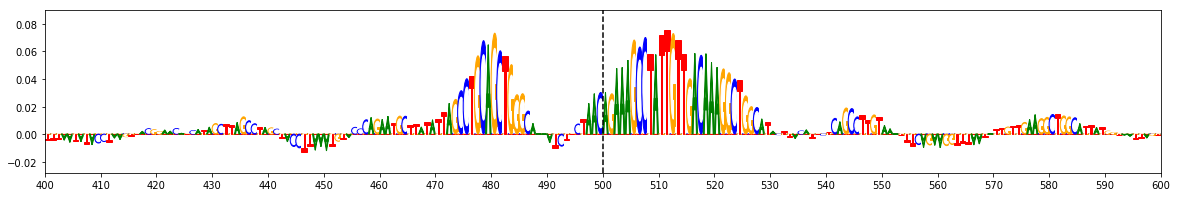

Effect Allele : A   ||   Explain Score : 1.9372   ||   Center / 200bp : 0.7145
Effect Sequence : ATCTTCTAAAAGAAAGCCTA


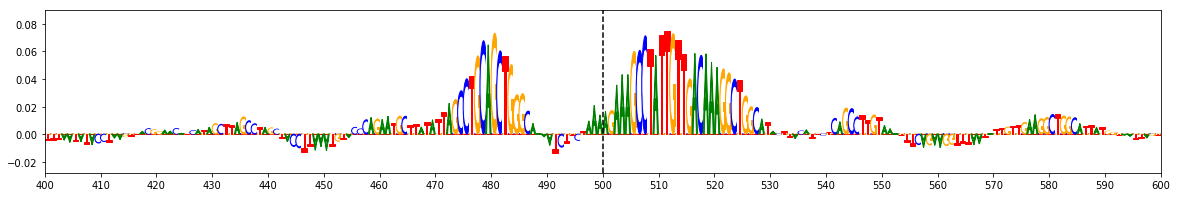

Allele Ratio : 0.9435   ||   Allele Difference : -0.1312  ||  ISM Score : -0.2075  ||  deltaSVM Score : -1.1501


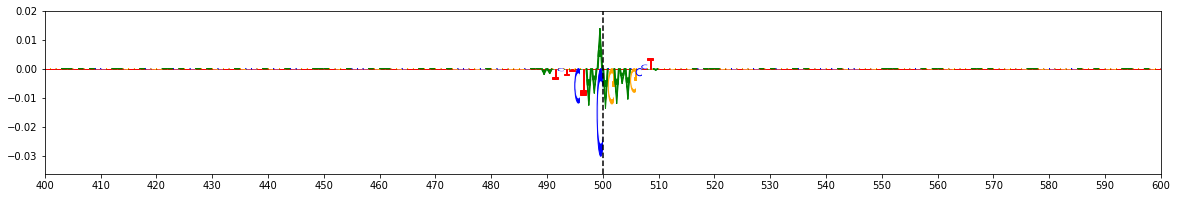


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs78710909   ||    chr2 : 127107345 - 127107346   ||    Locus: 191   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  4.44E-07
Alzheimers_Lambert_2013 	  NAN

Coloc:  False

Noneffect Allele : NAN   ||   Explain Score : 1.5964   ||   Center / 200bp : 0.7058
Noneffect Sequence : CACCGCCCCGGGGCGGGGAC


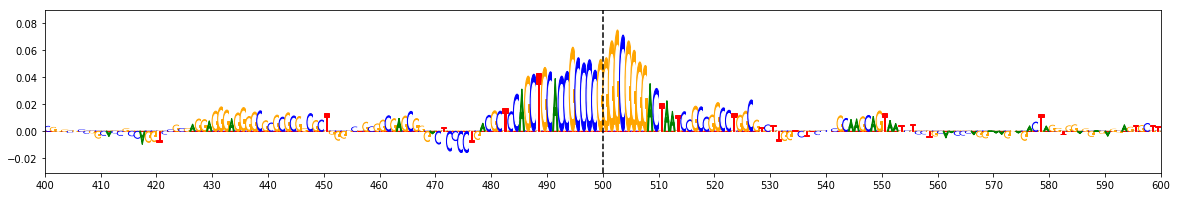

Effect Allele : NAN   ||   Explain Score : 1.4715   ||   Center / 200bp : 0.6829
Effect Sequence : CACCGCCCCCGGGCGGGGAC


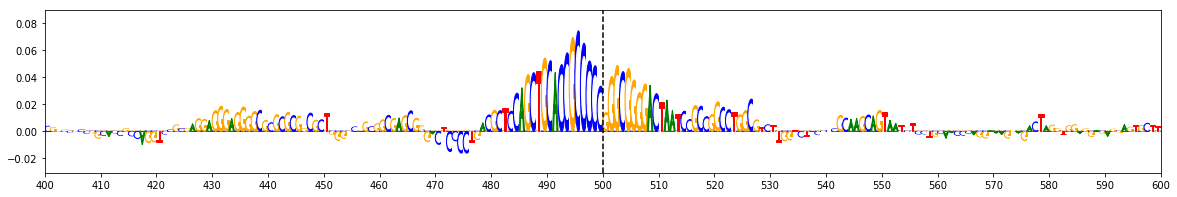

Allele Ratio : 0.9217   ||   Allele Difference : -0.1258  ||  ISM Score : -0.1065  ||  deltaSVM Score : -1.5051


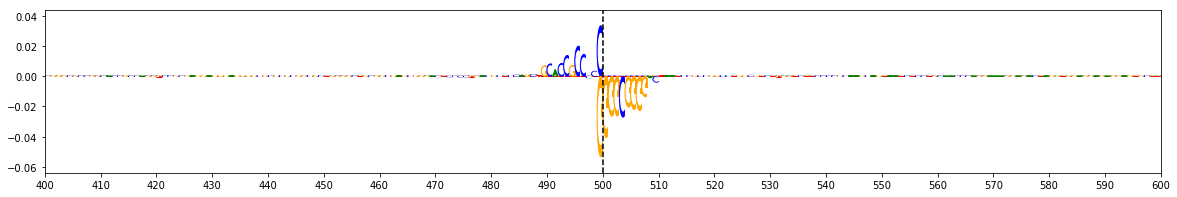


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11575896   ||    chr17 : 45894775 - 45894776   ||    Locus: 90   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.4319   ||   Center / 200bp : 0.6555
Noneffect Sequence : GCAGACTGGAGCTTCGTGCG


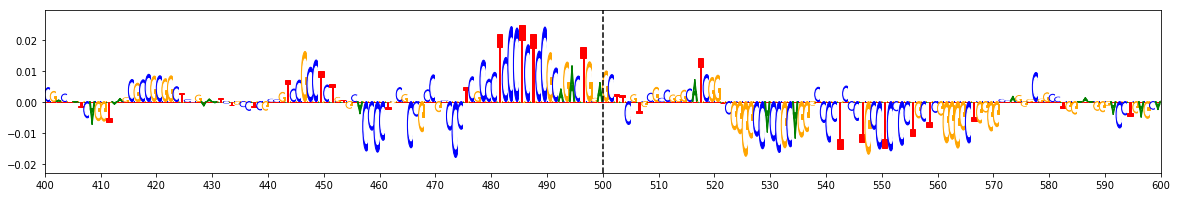

Effect Allele : G   ||   Explain Score : 0.3711   ||   Center / 200bp : 0.6206
Effect Sequence : GCAGACTGGGGCTTCGTGCG


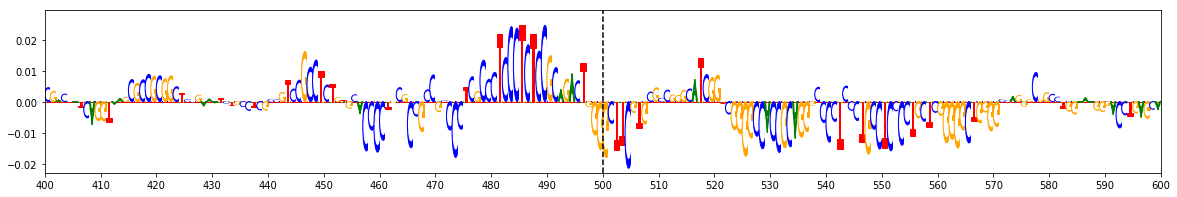

Allele Ratio : 0.8592   ||   Allele Difference : -0.1718  ||  ISM Score : -0.276  ||  deltaSVM Score : -1.5647


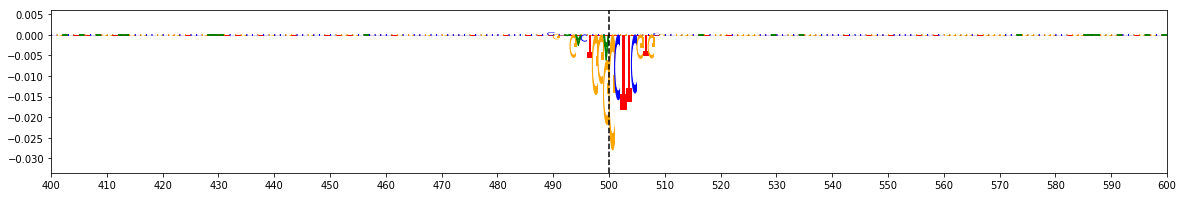


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs141801658   ||    chr17 : 45914204 - 45914205   ||    Locus: 93   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  4.43E-12

Coloc:  True

Noneffect Allele : D   ||   Explain Score : 0.4711   ||   Center / 200bp : 0.4164
Noneffect Sequence : CAGGGATCTGAGGGTGTGGG


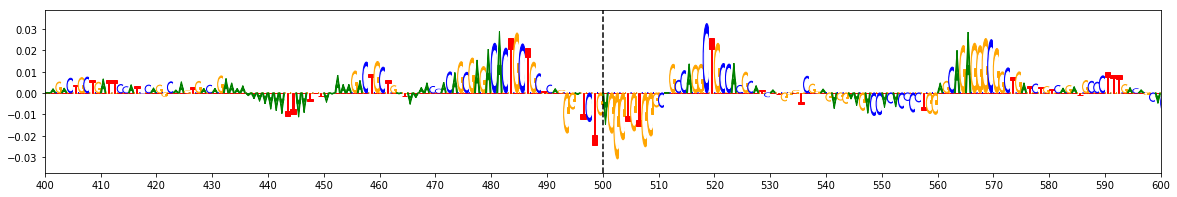

Effect Allele : I   ||   Explain Score : 0.2572   ||   Center / 200bp : 0.2816
Effect Sequence : CAGGGATCTGAGGGTGTGGG


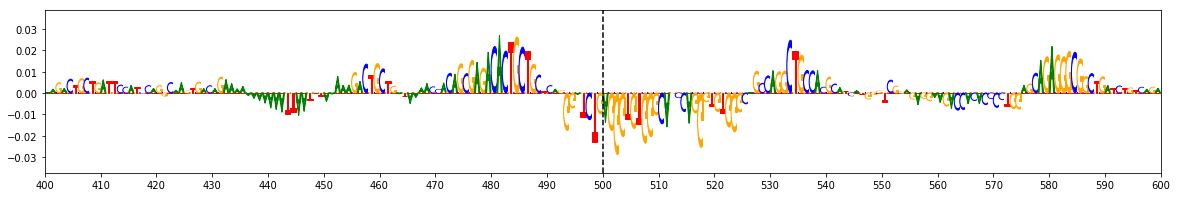

Allele Ratio : 0.546   ||   Allele Difference : -0.3567  ||  ISM Score : -0.4304  ||  deltaSVM Score : -3.0065


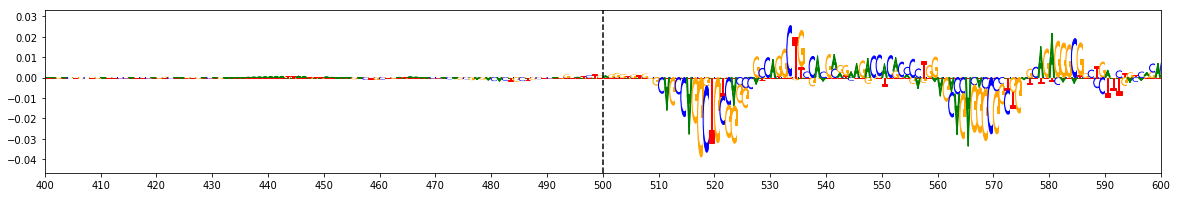


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2532307   ||    chr17 : 46143983 - 46143984   ||    Locus: 116   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.94E-22
Parkinsons_Pankratz_2012 	  5.16E-10

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 1.0424   ||   Center / 200bp : 0.5933
Noneffect Sequence : ACAAAGGGAGTATTTTCTAC


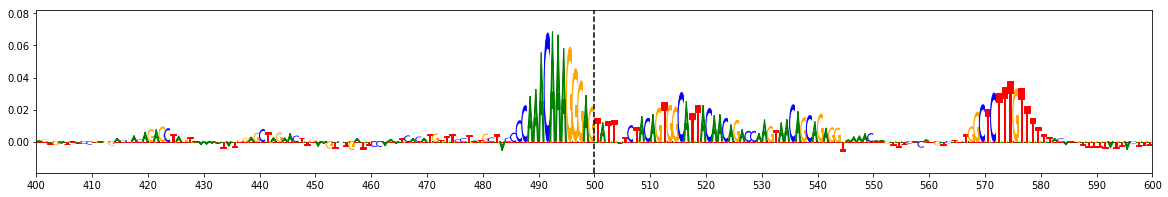

Effect Allele : A   ||   Explain Score : 0.8114   ||   Center / 200bp : 0.532
Effect Sequence : ACAAAGGGAATATTTTCTAC


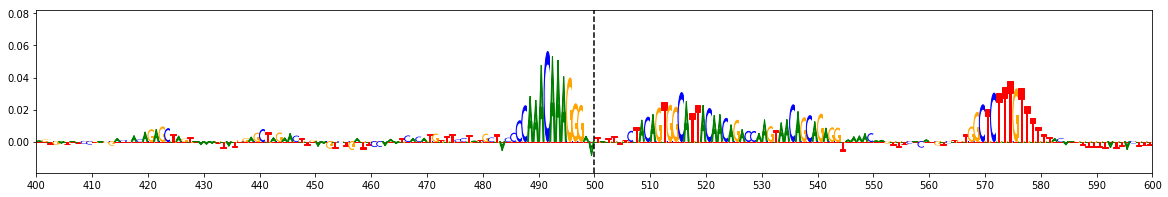

Allele Ratio : 0.7784   ||   Allele Difference : -0.2406  ||  ISM Score : -0.383  ||  deltaSVM Score : -2.2298


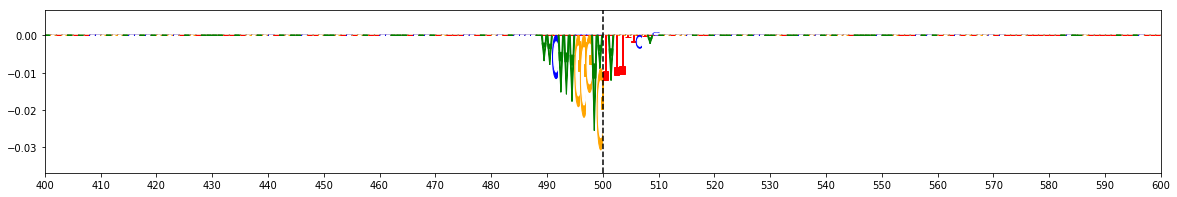


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [6]:
for idx in neg_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', neg_snps.at[idx, 'rsid'],
          '  ||   ', neg_snps.at[idx, 'chr'], ':', neg_snps.at[idx, 'start'], '-', neg_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', neg_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in neg_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
    
    print("Coloc: ", neg_snps.at[idx, 'coloc'])
    
    print()
    
    print('Noneffect Allele :', neg_snps.at[idx, 'noneffect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'noneffect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence :', noneffect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Effect Allele :', neg_snps.at[idx, 'effect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'effect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence :', effect_seqs[idx][490:510])
    
    a = plot_weights(merged_effect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(neg_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(neg_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(neg_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(neg_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_effect_scores[idx] - merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()

## Find Non-Effect Alleles that Improve Accessibility <a name='noneffect_table' />

In [7]:
pos_snps = snps.loc[snps['allele_ratio'] > 1]
pos_snps.sort_values(by=['effect_rank'], ascending=False, inplace=True)
display(pos_snps)

chr      start        end         rsid effect noneffect         ref  \
70   chr17   45825577   45825578    rs1912151      T         C           C   
79   chr17   45826181   45826182   rs62057150      T         C           C   
34   chr14   54882150   54882151   rs11158026      T         C           C   
123  chr17   46771150   46771151     rs199523      C         A           C   
73   chr17   45825722   45825723   rs41280118      T         C           C   
4     chr1  226737182  226737183  rs147889095      I         D  ACTGCCGCTG   
227   chr4     987143     987144   rs10902762      G         A           G   
279   chr8   22599691   22599692     rs755934      T         G           T   
121  chr17   46213392   46213393    rs2668662      T         C           T   
122  chr17   46771071   46771072     rs199524      T         G           G   
98   chr17   45942947   45942948   rs62062772      T         C           C   
271   chr6   27772886   27772887    rs9468223      T         C           C   
33   chr13   97212766   97212767    rs4771268      T         C           T   
194   chr2  127108470  127108471   rs35860453      T         C           C   
22   chr11   86068267   86068268    rs2458500      A         G           A   
125  chr17   62065844   62065845    rs3809753      T         C           C   
10   chr10  102245652  102245653    rs2296887      T         C           T   
176  chr19   45098342   45098343  rs138137383      C         G           G   
96   chr17   45942313   45942314   rs62062770      T         C           T   
203   chr3   48692682   48692683   rs12493578      T         C           T   
178  chr19   45137506   45137507  rs536518226      C         G           G   
32   chr12  122842050  122842051   rs10847864      T         G           G   
275   chr7   23106569   23106570    rs2072369      A         G           A   
92   chr17   45895713   45895714   rs74548327      G         A           A   
187   chr2  127106969  127106970   rs11554586      A         G           G   
133  chr17   78426733   78426734   rs72914883      G         A           A   
112  chr17   46013337   46013338   rs62062266      G         A           A   
245   chr4   89829438   89829439    rs2737005    NAN       NAN           A   
229   chr4   18022497   18022498    rs1380294      T         C           C   
272   chr7   23105294   23105295   rs10241208      C         G           G   
..     ...        ...        ...          ...    ...       ...         ...   
81   chr17   45849422   45849423    rs8064870      T         C           T   
202   chr3   48685868   48685869    rs6792510      G         C           G   
213   chr3   52339932   52339933  rs149814394      G         A           G   
86   chr17   45894114   45894115   rs80233201      T         C           T   
11   chr10  119651404  119651405  rs144814361      T         C           C   
39   chr14   67522379   67522380    rs4902477      G         A           G   
211   chr3   52307781   52307782  rs149776414      G         A           G   
180   chr2   95264881   95264882    rs4854249      G         A           A   
225   chr4     986675     986676    rs4690220      G         A           A   
119  chr17   46192692   46192693    rs2696633      T         A           A   
20   chr11   65889092   65889093    rs2231884      T         C           C   
232   chr4   89709523   89709524     rs356177    NAN       NAN           C   
104  chr17   46002200   46002201   rs17573447      T         C           C   
224   chr4     973656     973657   rs13137144      G         A           G   
12   chr11   47272247   47272248   rs10501320      C         G           G   
65   chr17   45722437   45722438   rs77819001      C         A           C   
0     chr1  155135690  155135691   rs12726330      G         A           G   
171  chr19   45001268   45001269  rs117612135      T         C           C   
154  chr19   44915228   44915229   rs12691088      A         G           G   
281   chr8   22623005   22623

## Visualize Top Non-Effect Alleles <a name='noneffect_viz' />

RSID: rs1912151   ||    chr17 : 45825577 - 45825578   ||    Locus: 70   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.33E-22
Parkinsons_Pankratz_2012 	  1.22E-09

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.2439   ||  Center / 200bp: 0.3086
Effect Sequence: GGTTCACTGTTCACCGTGTG


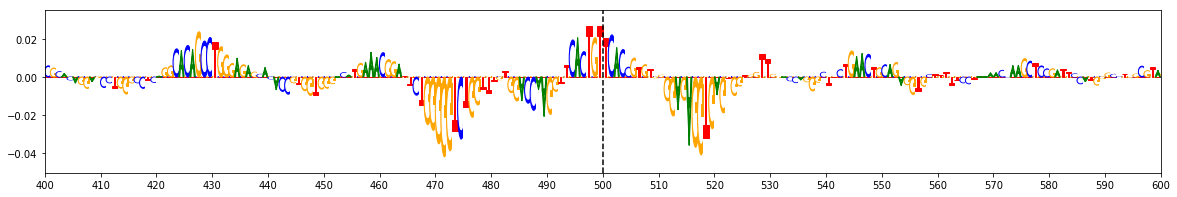

Noneffect Allele: C   ||  Explain Score: 0.0071   ||  Center / 200bp: 0.0128
Noneffect Sequence: GGTTCACTGCTCACCGTGTG


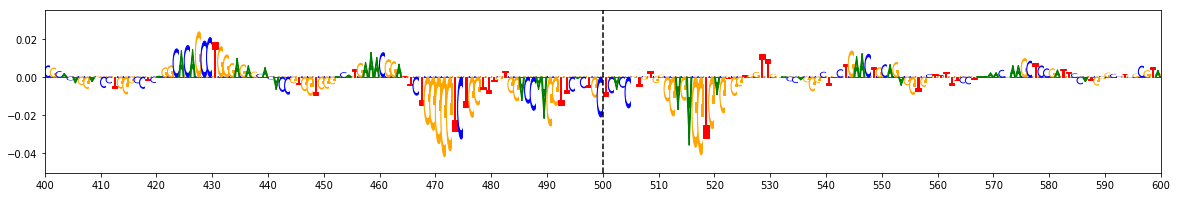

Allele Ratio : 34.5403   ||   Allele Difference : 0.3774  ||  ISM Score : 0.594  ||  deltaSVM Score : 3.4278


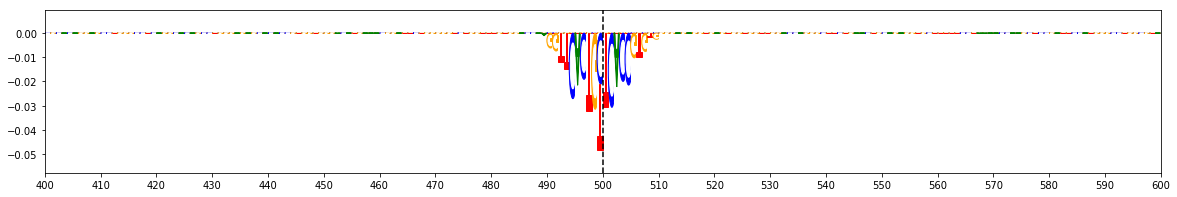


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62057150   ||    chr17 : 45826181 - 45826182   ||    Locus: 79   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.33E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.8134   ||  Center / 200bp: 0.6629
Effect Sequence: CGTGGCCATTGGTCGGGGTG


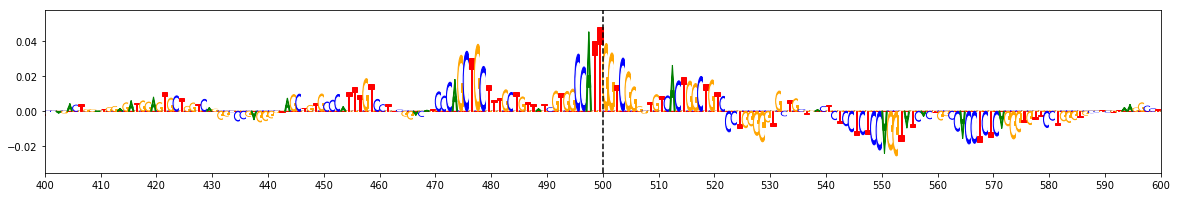

Noneffect Allele: C   ||  Explain Score: 0.4673   ||  Center / 200bp: 0.53
Noneffect Sequence: CGTGGCCATCGGTCGGGGTG


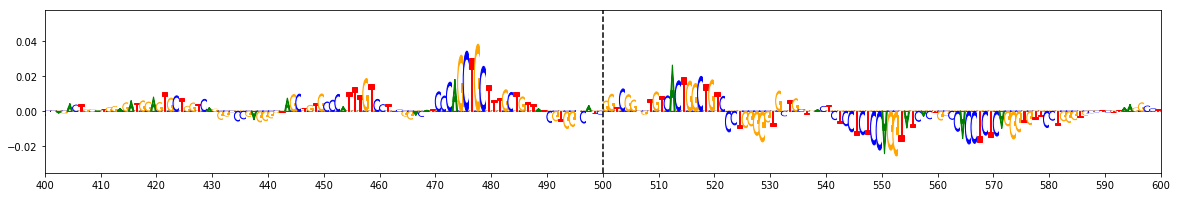

Allele Ratio : 1.7406   ||   Allele Difference : 0.3925  ||  ISM Score : 0.6236  ||  deltaSVM Score : 3.599


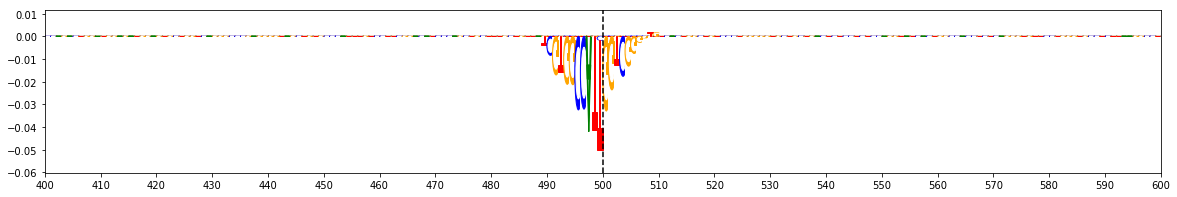


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11158026   ||    chr14 : 54882150 - 54882151   ||    Locus: 34   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  2.65E-07
Nalls_23andMe 		  2.65E-07

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.6318   ||  Center / 200bp: 0.7069
Effect Sequence: GGAACCGCATGCACAGTGGT


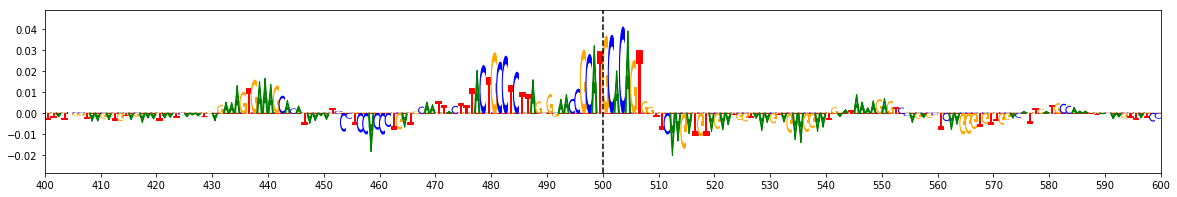

Noneffect Allele: C   ||  Explain Score: 0.4111   ||  Center / 200bp: 0.6107
Noneffect Sequence: GGAACCGCACGCACAGTGGT


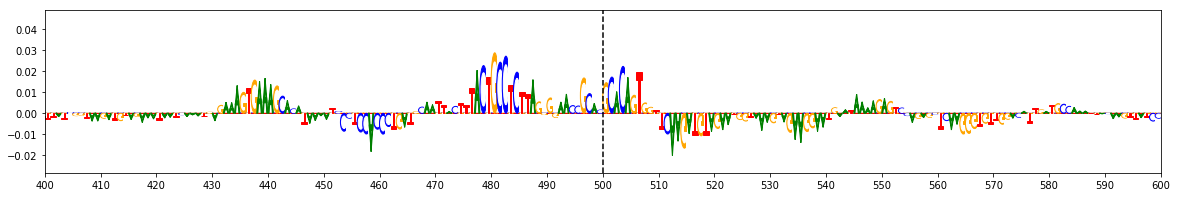

Allele Ratio : 1.5369   ||   Allele Difference : 0.2205  ||  ISM Score : 0.3451  ||  deltaSVM Score : 1.9517


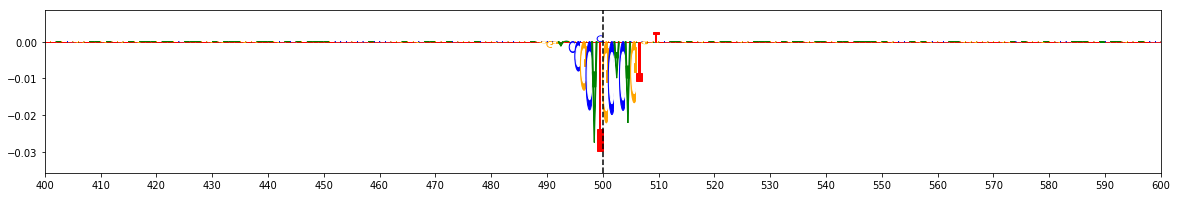


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs199523   ||    chr17 : 46771150 - 46771151   ||    Locus: 123   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  9.49E-14

Coloc:  True

Effect Allele: C   ||  Explain Score: 0.732   ||  Center / 200bp: 0.3977
Effect Sequence: GCCCTCCTGCGCCACCTACA


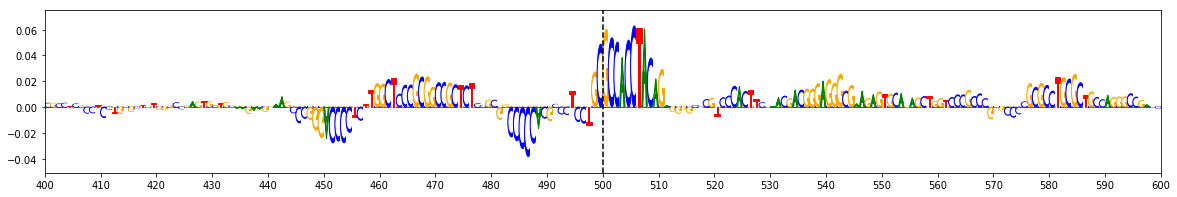

Noneffect Allele: A   ||  Explain Score: 0.2777   ||  Center / 200bp: 0.2
Noneffect Sequence: GCCCTCCTGAGCCACCTACA


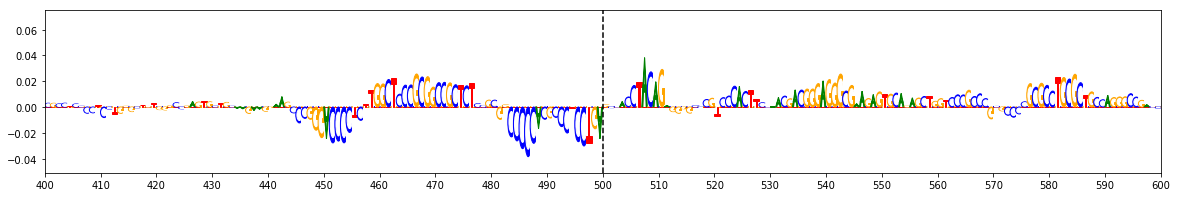

Allele Ratio : 2.6357   ||   Allele Difference : 0.5756  ||  ISM Score : 0.9131  ||  deltaSVM Score : 5.2695


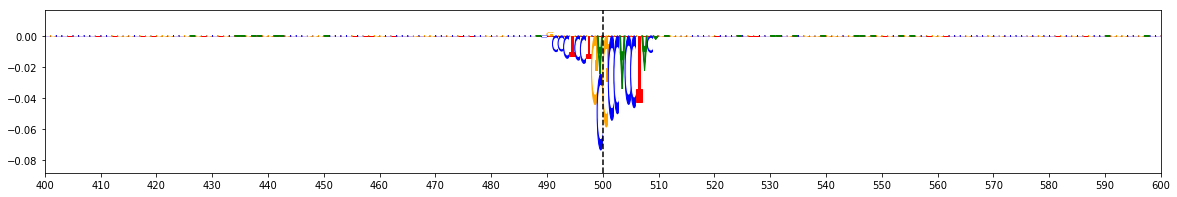


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs41280118   ||    chr17 : 45825722 - 45825723   ||    Locus: 73   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.33E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.6636   ||  Center / 200bp: 0.6444
Effect Sequence: GCTCCTCTGTGTGCTGTTGC


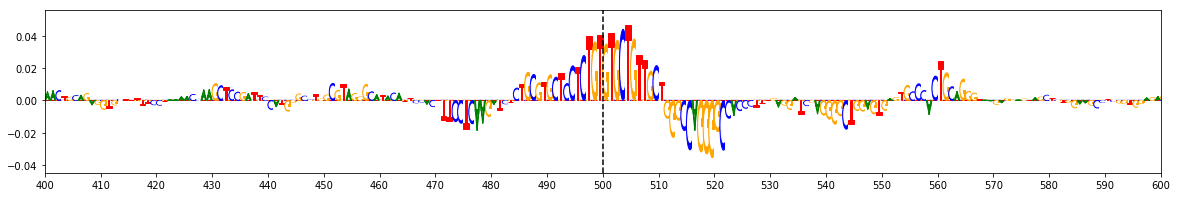

Noneffect Allele: C   ||  Explain Score: 0.411   ||  Center / 200bp: 0.5324
Noneffect Sequence: GCTCCTCTGCGTGCTGTTGC


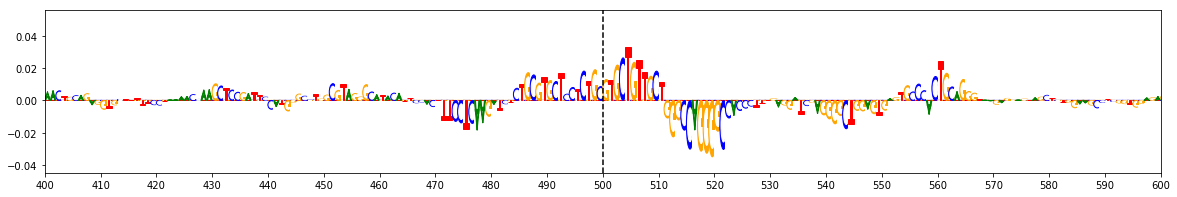

Allele Ratio : 1.6146   ||   Allele Difference : 0.2471  ||  ISM Score : 0.3916  ||  deltaSVM Score : 2.2119


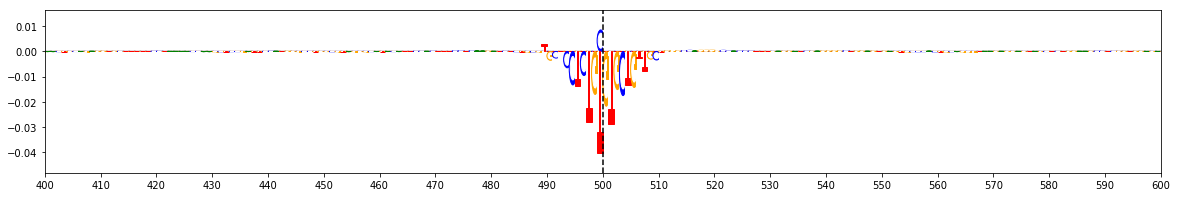


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs147889095   ||    chr1 : 226737182 - 226737183   ||    Locus: 4   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  1.77E-05
Nalls_23andMe 		  1.77E-05

Coloc:  False

Effect Allele: I   ||  Explain Score: 0.6205   ||  Center / 200bp: 0.6459
Effect Sequence: ACTGCCGCTGCCACTGCCGC


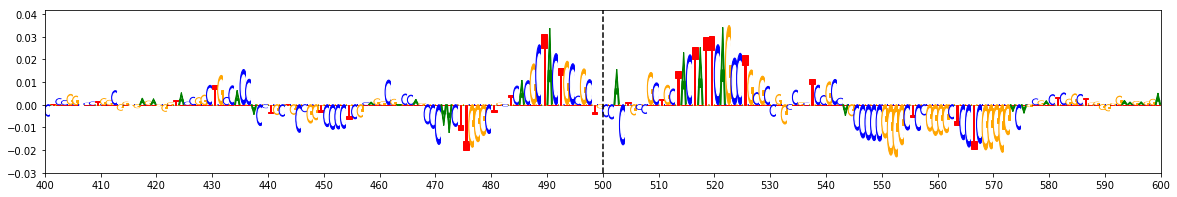

Noneffect Allele: D   ||  Explain Score: 0.3971   ||  Center / 200bp: 0.4424
Noneffect Sequence: ACTGCCGCTGCTGCCGCTGC


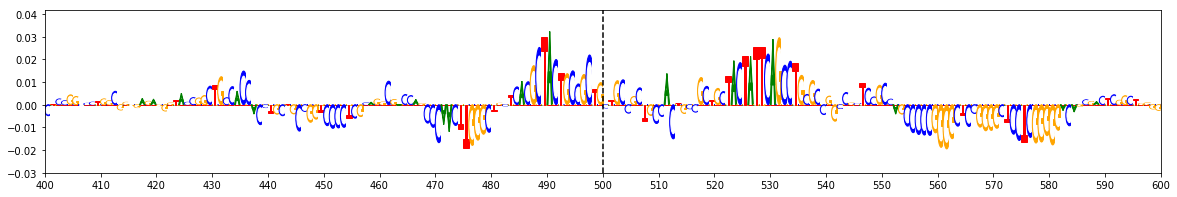

Allele Ratio : 1.5626   ||   Allele Difference : 0.2287  ||  ISM Score : 0.2808  ||  deltaSVM Score : 2.003


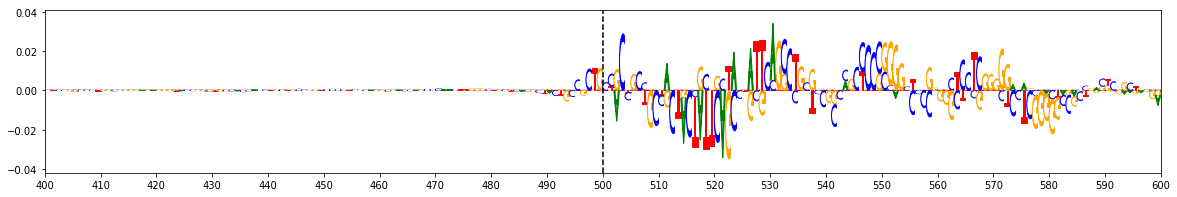


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10902762   ||    chr4 : 987143 - 987144   ||    Locus: 227   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.90E-11

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.3637   ||  Center / 200bp: 0.4103
Effect Sequence: CCTGGCCGCGCCCCCGGTGG


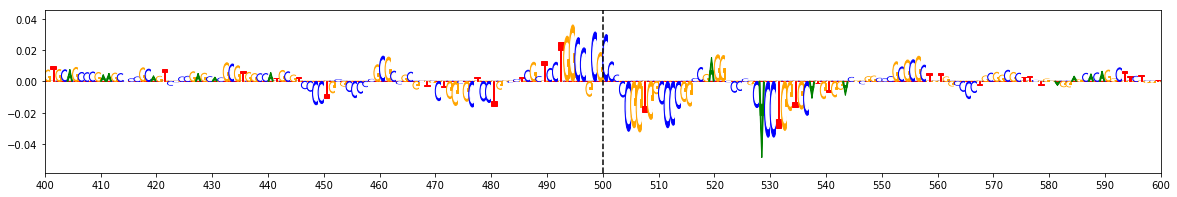

Noneffect Allele: A   ||  Explain Score: 0.1698   ||  Center / 200bp: 0.2423
Noneffect Sequence: CCTGGCCGCACCCCCGGTGG


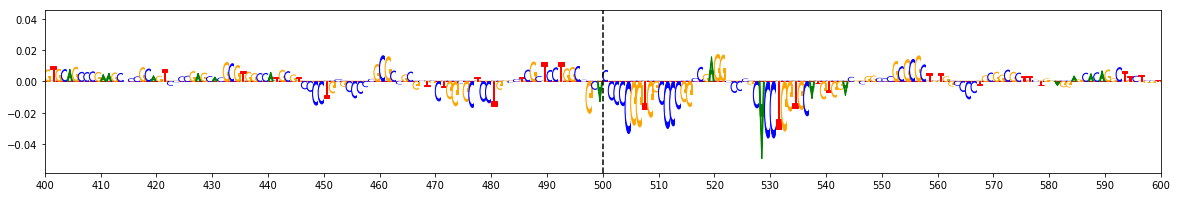

Allele Ratio : 2.142   ||   Allele Difference : 0.2509  ||  ISM Score : 0.4089  ||  deltaSVM Score : 2.4312


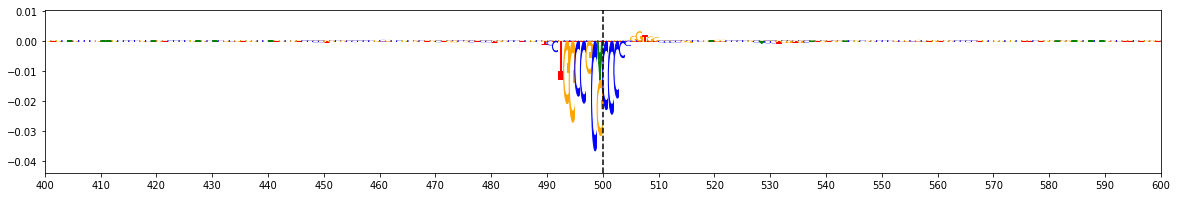


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs755934   ||    chr8 : 22599691 - 22599692   ||    Locus: 279   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  5.11E-02
Nalls_23andMe 		  5.11E-02

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.7039   ||  Center / 200bp: 0.5184
Effect Sequence: GCGGCTGCATTGGCCGGGGC


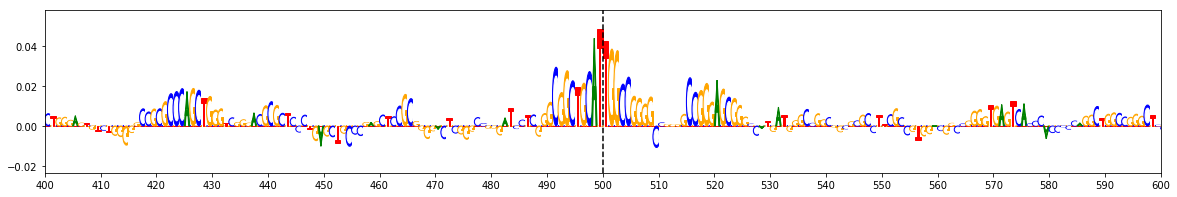

Noneffect Allele: G   ||  Explain Score: 0.4218   ||  Center / 200bp: 0.3936
Noneffect Sequence: GCGGCTGCAGTGGCCGGGGC


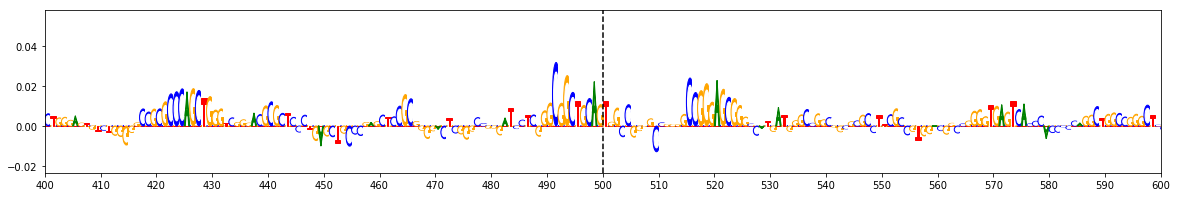

Allele Ratio : 1.6687   ||   Allele Difference : 0.2972  ||  ISM Score : 0.4749  ||  deltaSVM Score : 2.953


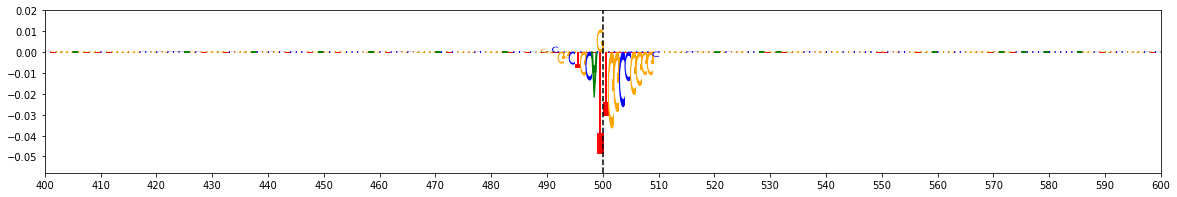


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2668662   ||    chr17 : 46213392 - 46213393   ||    Locus: 121   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  7.45E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.7884   ||  Center / 200bp: 0.7508
Effect Sequence: TCCGCCTGCTGGGTTCACAC


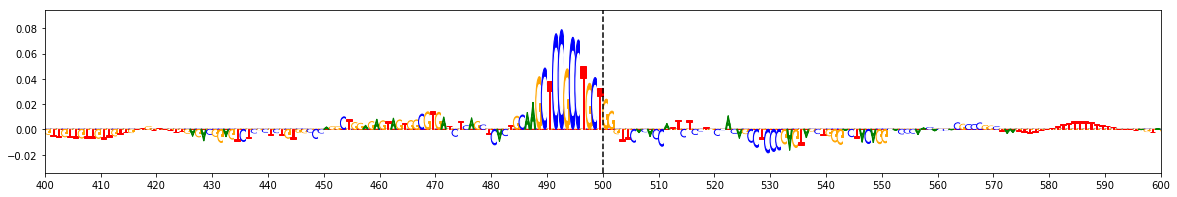

Noneffect Allele: C   ||  Explain Score: 0.7371   ||  Center / 200bp: 0.7379
Noneffect Sequence: TCCGCCTGCCGGGTTCACAC


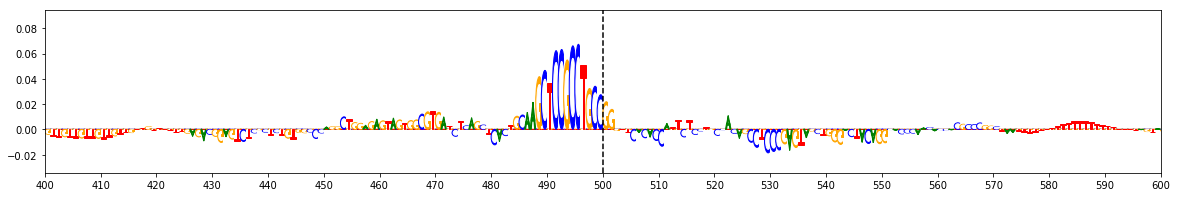

Allele Ratio : 1.0696   ||   Allele Difference : 0.0393  ||  ISM Score : 0.0721  ||  deltaSVM Score : 0.4643


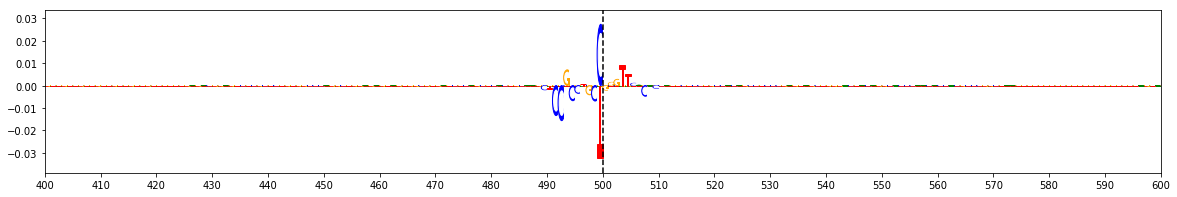


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs199524   ||    chr17 : 46771071 - 46771072   ||    Locus: 122   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  9.53E-14
Parkinsons_Pankratz_2012 	  3.32E-10

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.4236   ||  Center / 200bp: 0.3557
Effect Sequence: CTGGGCTGTTGGCCGAGTGC


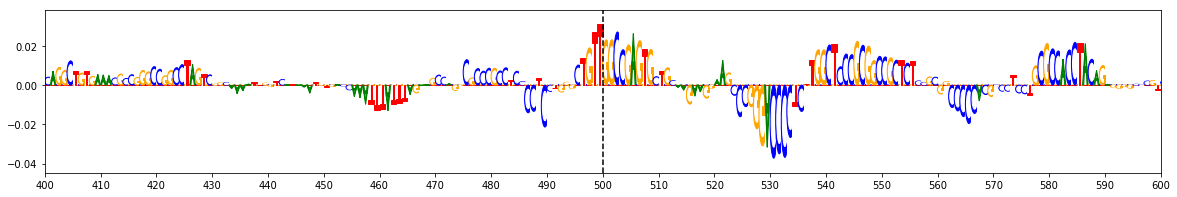

Noneffect Allele: G   ||  Explain Score: 0.1905   ||  Center / 200bp: 0.1991
Noneffect Sequence: CTGGGCTGTGGGCCGAGTGC


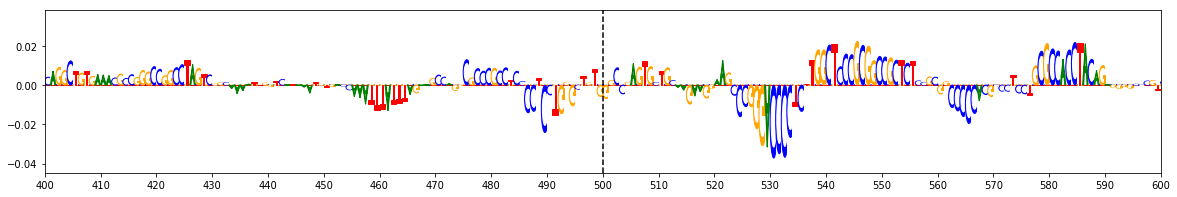

Allele Ratio : 2.2235   ||   Allele Difference : 0.2902  ||  ISM Score : 0.4584  ||  deltaSVM Score : 2.6456


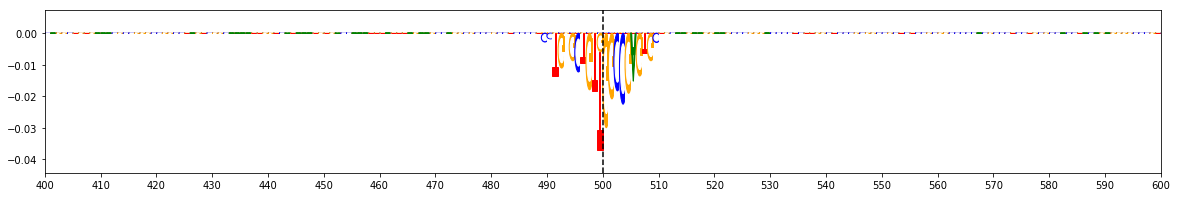


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62062772   ||    chr17 : 45942947 - 45942948   ||    Locus: 98   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.65E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.9305   ||  Center / 200bp: 0.6274
Effect Sequence: GACTCCCTGTACTGCGCTGT


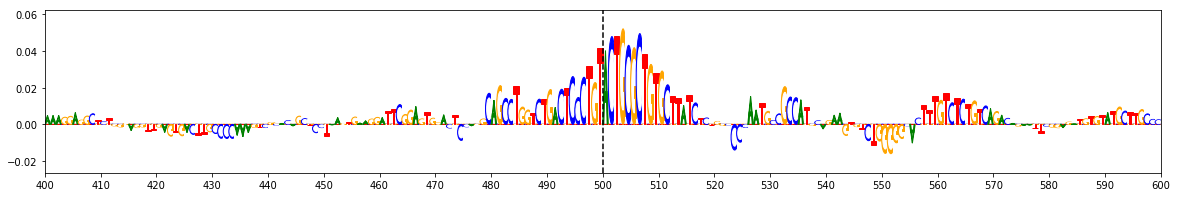

Noneffect Allele: C   ||  Explain Score: 0.74   ||  Center / 200bp: 0.5736
Noneffect Sequence: GACTCCCTGCACTGCGCTGT


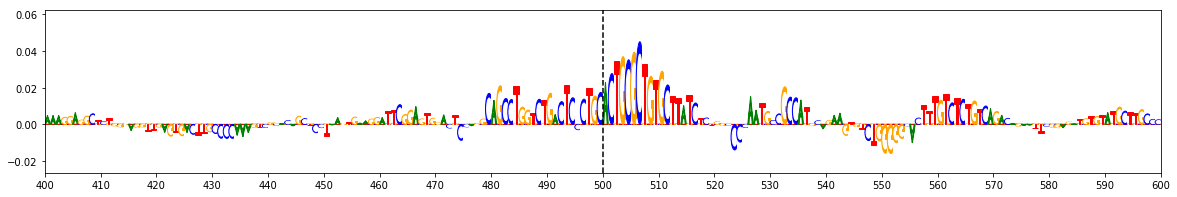

Allele Ratio : 1.2574   ||   Allele Difference : 0.1933  ||  ISM Score : 0.3067  ||  deltaSVM Score : 1.7197


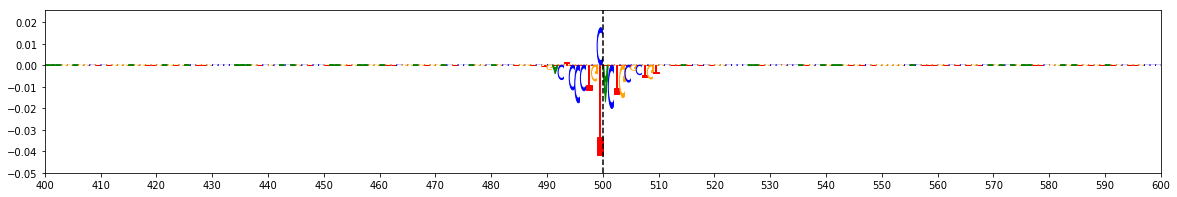


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs9468223   ||    chr6 : 27772886 - 27772887   ||    Locus: 271   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  2.29E-06

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.5819   ||  Center / 200bp: 0.6987
Effect Sequence: CCAGCGCCATGTTGGACTCA


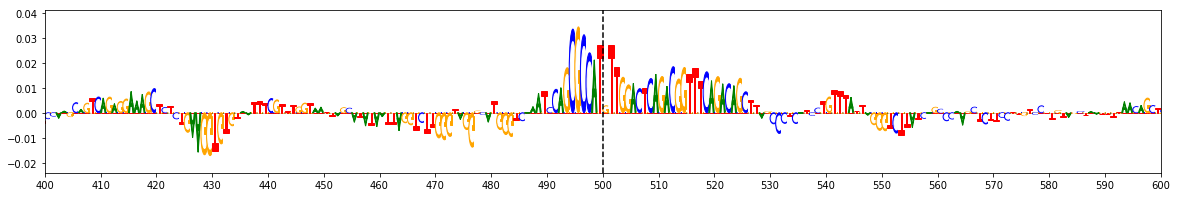

Noneffect Allele: C   ||  Explain Score: 0.5164   ||  Center / 200bp: 0.673
Noneffect Sequence: CCAGCGCCACGTTGGACTCA


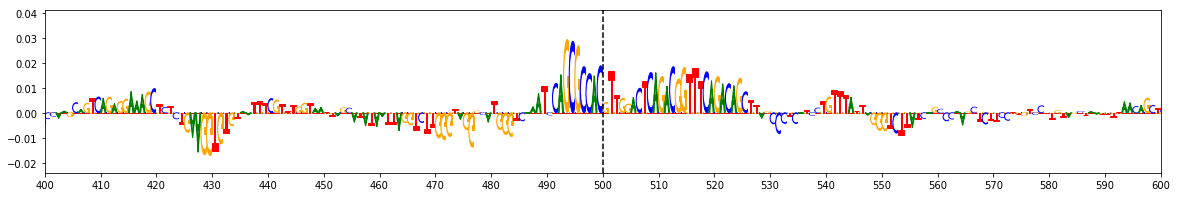

Allele Ratio : 1.1269   ||   Allele Difference : 0.0664  ||  ISM Score : 0.1053  ||  deltaSVM Score : 0.5683


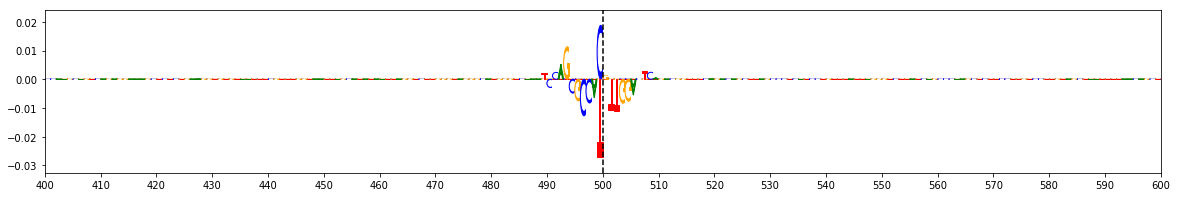


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs4771268   ||    chr13 : 97212766 - 97212767   ||    Locus: 33   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.06E-01

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.5898   ||  Center / 200bp: 0.4359
Effect Sequence: ATGTCTCTCTTTGTCGTCAA


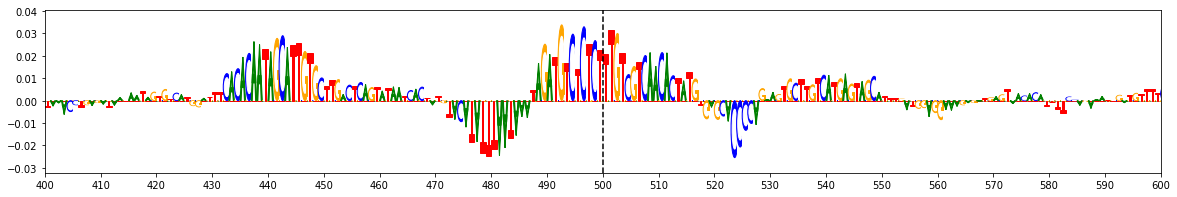

Noneffect Allele: C   ||  Explain Score: 0.3402   ||  Center / 200bp: 0.3083
Noneffect Sequence: ATGTCTCTCCTTGTCGTCAA


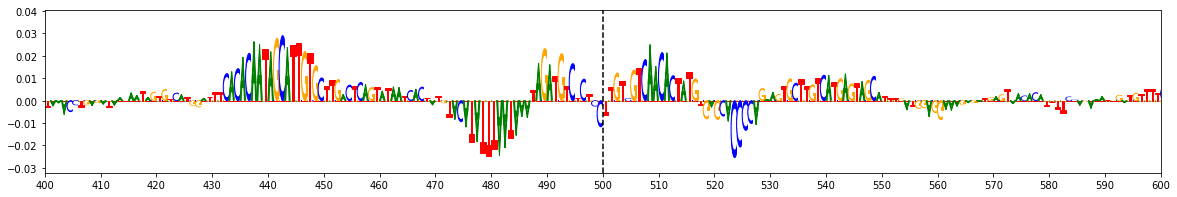

Allele Ratio : 1.7337   ||   Allele Difference : 0.27  ||  ISM Score : 0.4203  ||  deltaSVM Score : 2.4415


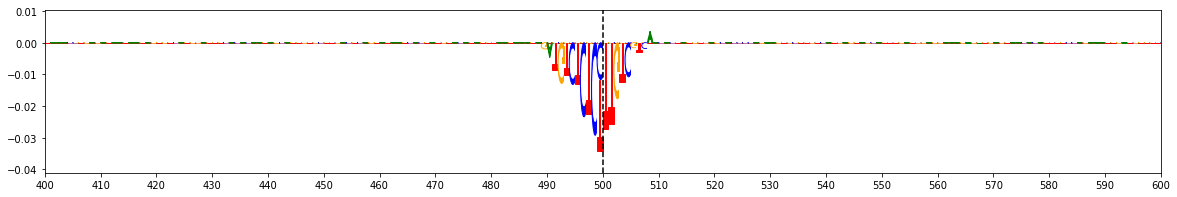


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs35860453   ||    chr2 : 127108470 - 127108471   ||    Locus: 194   ||    IDR Peak: False

GWAS:
Alzheimers_Kunkle_2019 		  1.65E-10
Alzheimers_Lambert_2013 	  6.52E-08

Coloc:  False

Effect Allele: T   ||  Explain Score: 1.0827   ||  Center / 200bp: 0.7046
Effect Sequence: CAGTGTGTTTGTCTGTCCTC


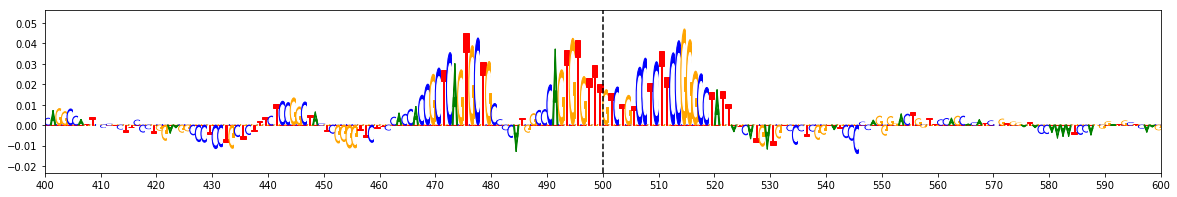

Noneffect Allele: C   ||  Explain Score: 1.0535   ||  Center / 200bp: 0.6987
Noneffect Sequence: CAGTGTGTTCGTCTGTCCTC


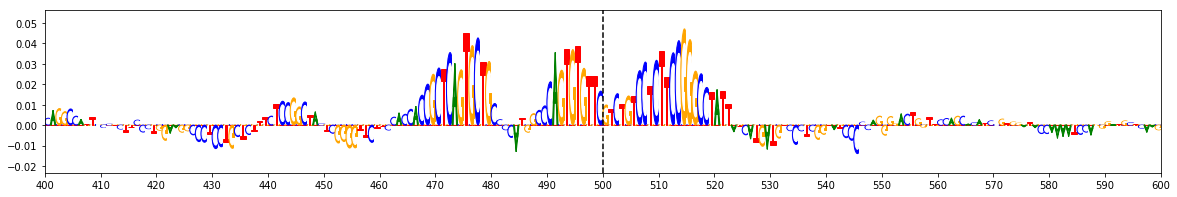

Allele Ratio : 1.0277   ||   Allele Difference : 0.0292  ||  ISM Score : 0.0436  ||  deltaSVM Score : 0.2659


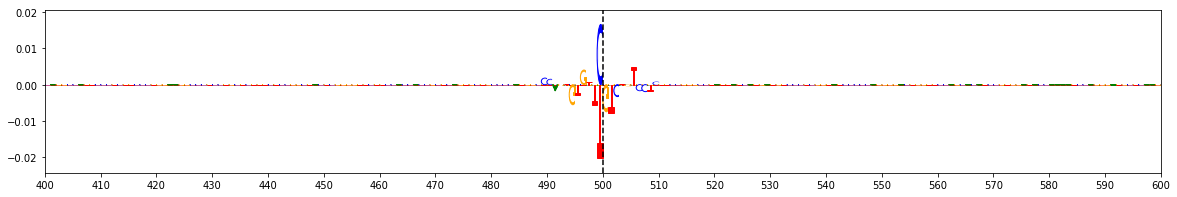


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2458500   ||    chr11 : 86068267 - 86068268   ||    Locus: 22   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.05E-11

Coloc:  False

Effect Allele: A   ||  Explain Score: 0.9893   ||  Center / 200bp: 0.6372
Effect Sequence: GACGCTCAGACGAGGGCGAC


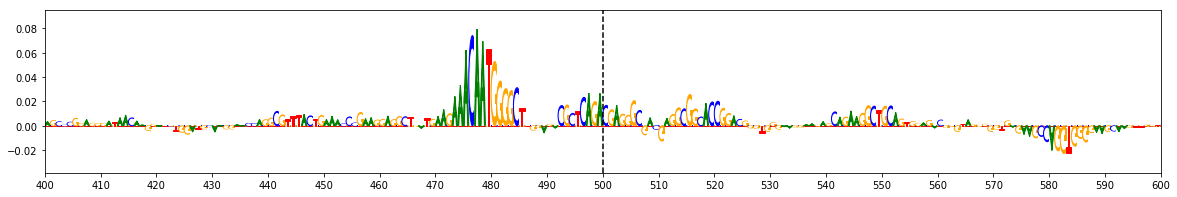

Noneffect Allele: G   ||  Explain Score: 0.8775   ||  Center / 200bp: 0.6089
Noneffect Sequence: GACGCTCAGGCGAGGGCGAC


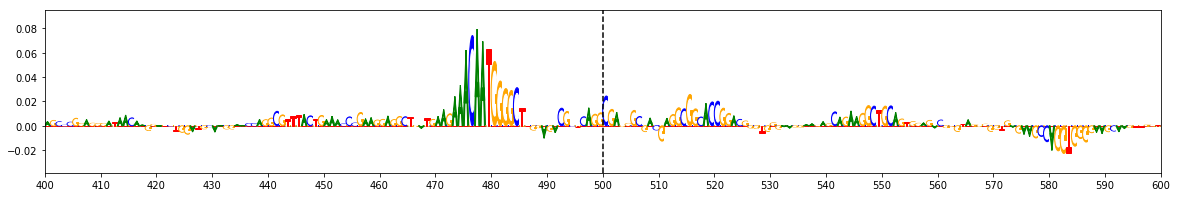

Allele Ratio : 1.1274   ||   Allele Difference : 0.1234  ||  ISM Score : 0.1935  ||  deltaSVM Score : 1.1158


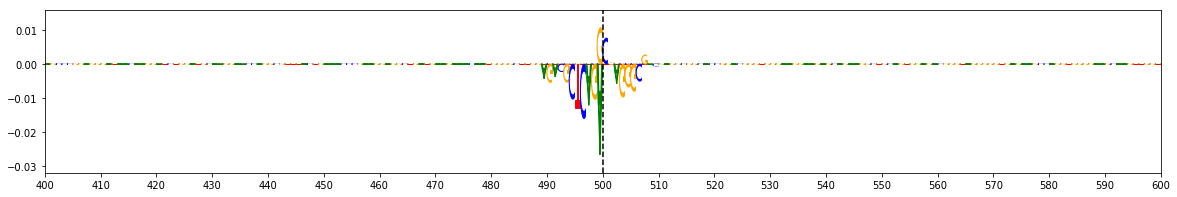


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3809753   ||    chr17 : 62065844 - 62065845   ||    Locus: 125   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.70E-04

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.8702   ||  Center / 200bp: 0.5593
Effect Sequence: TGGCCTCACTGGCTGGACGC


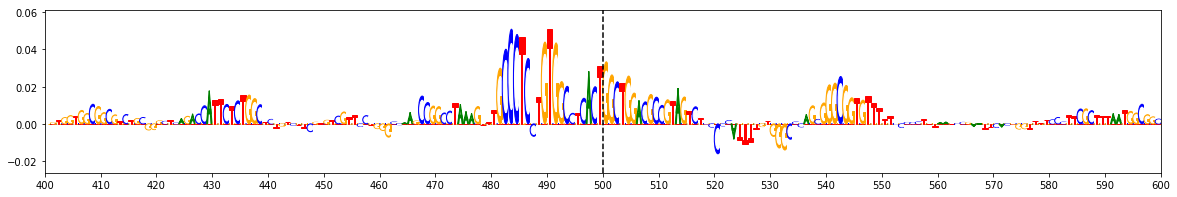

Noneffect Allele: C   ||  Explain Score: 0.6834   ||  Center / 200bp: 0.4996
Noneffect Sequence: TGGCCTCACCGGCTGGACGC


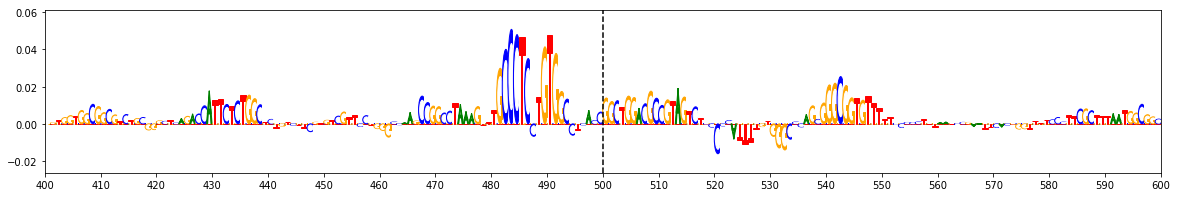

Allele Ratio : 1.2732   ||   Allele Difference : 0.1968  ||  ISM Score : 0.3078  ||  deltaSVM Score : 1.7682


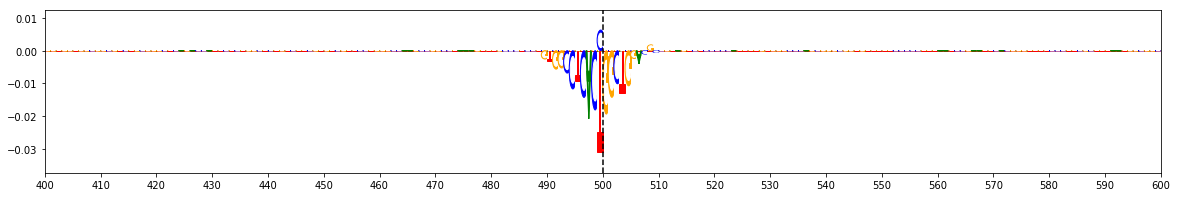


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2296887   ||    chr10 : 102245652 - 102245653   ||    Locus: 10   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  6.98E-03

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.5068   ||  Center / 200bp: 0.4137
Effect Sequence: GAAACAGGCTCCTTCTCTTC


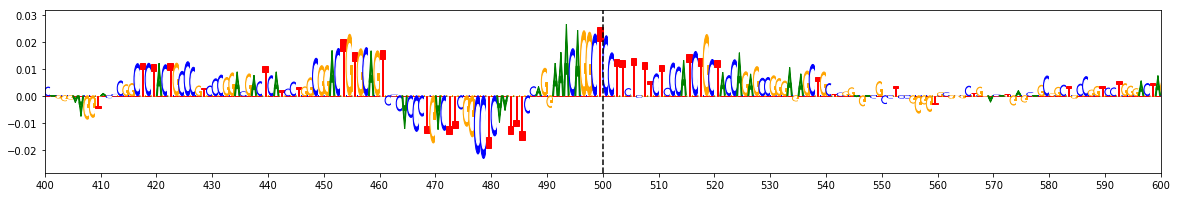

Noneffect Allele: C   ||  Explain Score: 0.3052   ||  Center / 200bp: 0.2982
Noneffect Sequence: GAAACAGGCCCCTTCTCTTC


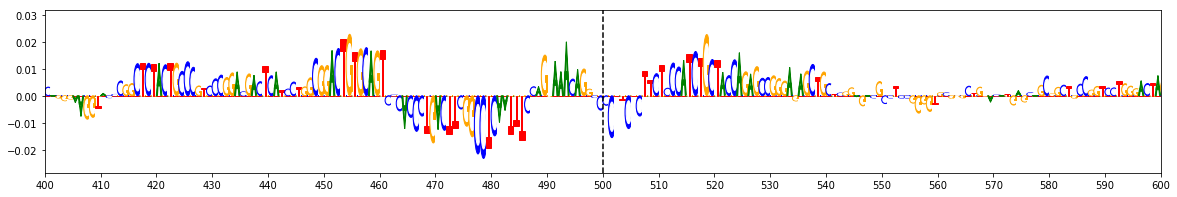

Allele Ratio : 1.6606   ||   Allele Difference : 0.2434  ||  ISM Score : 0.3789  ||  deltaSVM Score : 2.1666


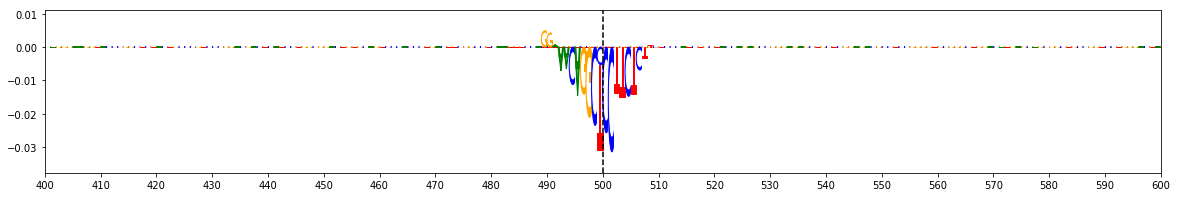


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs138137383   ||    chr19 : 45098342 - 45098343   ||    Locus: 176   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  9.94E-19
Alzheimers_Kunkle_2019 		  7.62E-14

Coloc:  True

Effect Allele: C   ||  Explain Score: 0.5612   ||  Center / 200bp: 0.6222
Effect Sequence: CTGAGGCTCCGCTGGTCTCC


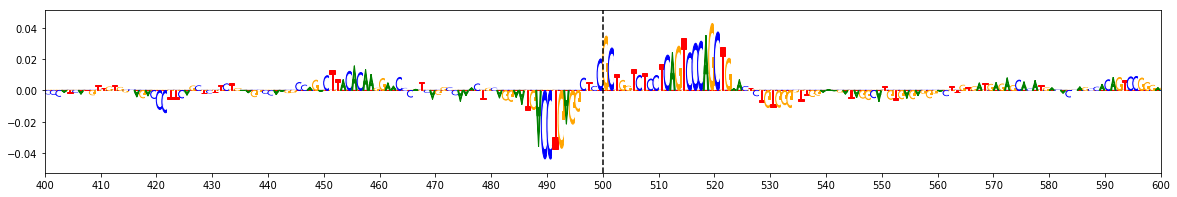

Noneffect Allele: G   ||  Explain Score: 0.5094   ||  Center / 200bp: 0.5994
Noneffect Sequence: CTGAGGCTCGGCTGGTCTCC


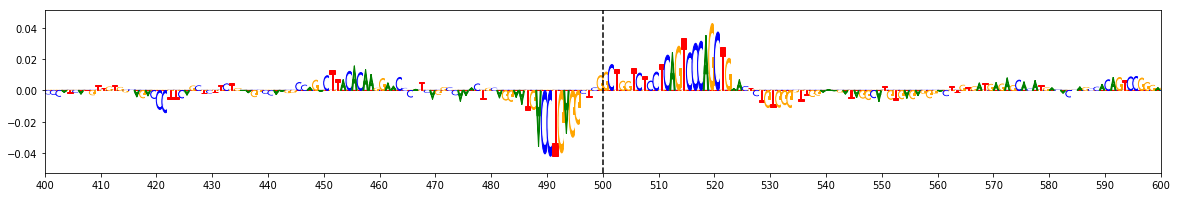

Allele Ratio : 1.1017   ||   Allele Difference : 0.0829  ||  ISM Score : 0.1293  ||  deltaSVM Score : 0.7494


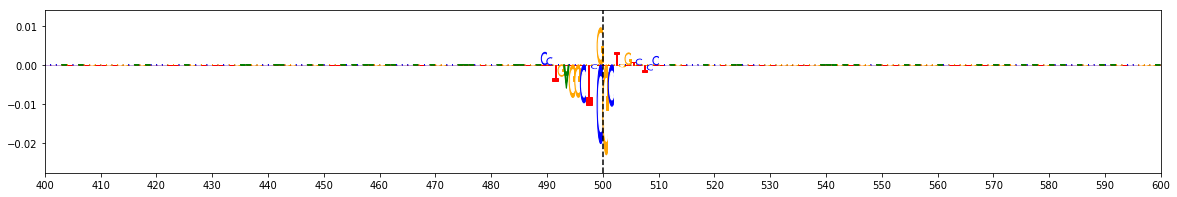


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62062770   ||    chr17 : 45942313 - 45942314   ||    Locus: 96   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.67E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.8557   ||  Center / 200bp: 0.5791
Effect Sequence: CGTTTCTTCTTCCTTACAAA


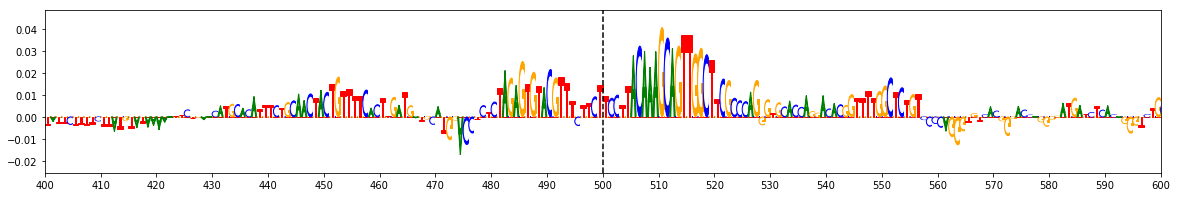

Noneffect Allele: C   ||  Explain Score: 0.7236   ||  Center / 200bp: 0.5378
Noneffect Sequence: CGTTTCTTCCTCCTTACAAA


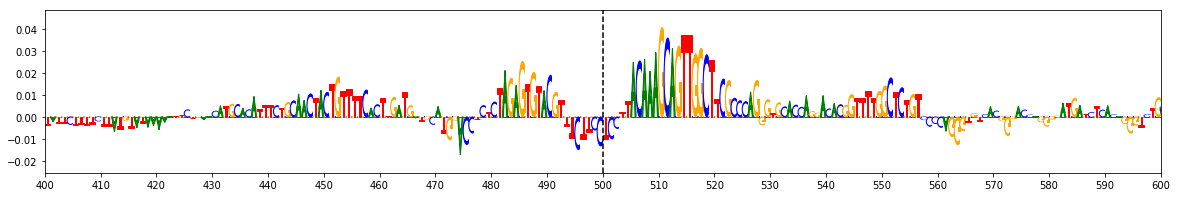

Allele Ratio : 1.1826   ||   Allele Difference : 0.2174  ||  ISM Score : 0.3387  ||  deltaSVM Score : 1.976


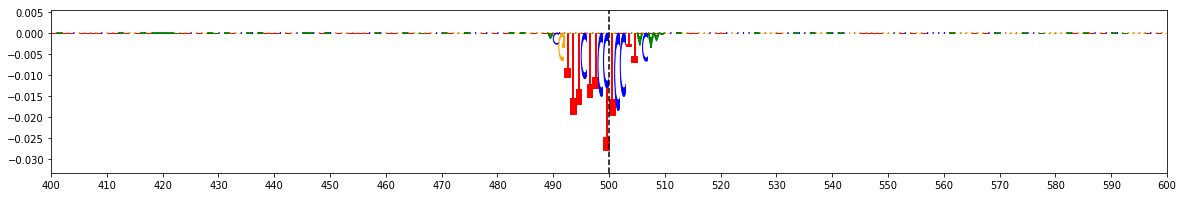


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs12493578   ||    chr3 : 48692682 - 48692683   ||    Locus: 203   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  2.04E-04
Nalls_23andMe 		  2.04E-04

Coloc:  False

Effect Allele: T   ||  Explain Score: 1.1159   ||  Center / 200bp: 0.5514
Effect Sequence: ACTGCTACATCTCCAGAACA


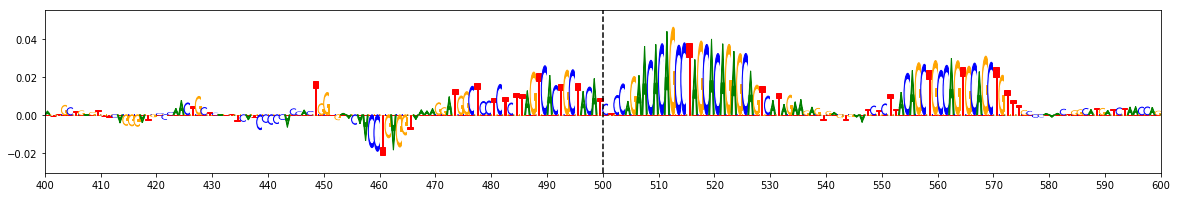

Noneffect Allele: C   ||  Explain Score: 0.9113   ||  Center / 200bp: 0.5011
Noneffect Sequence: ACTGCTACACCTCCAGAACA


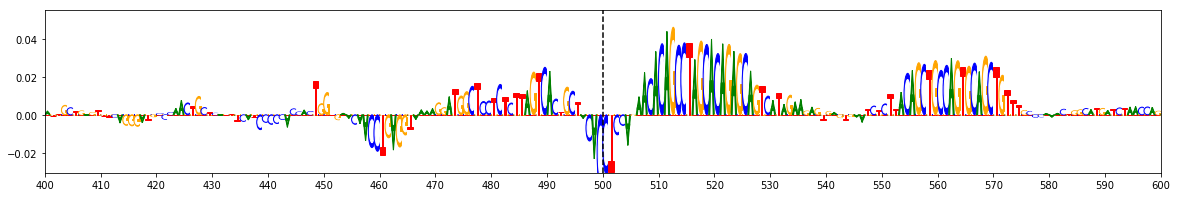

Allele Ratio : 1.2245   ||   Allele Difference : 0.3766  ||  ISM Score : 0.586  ||  deltaSVM Score : 3.3847


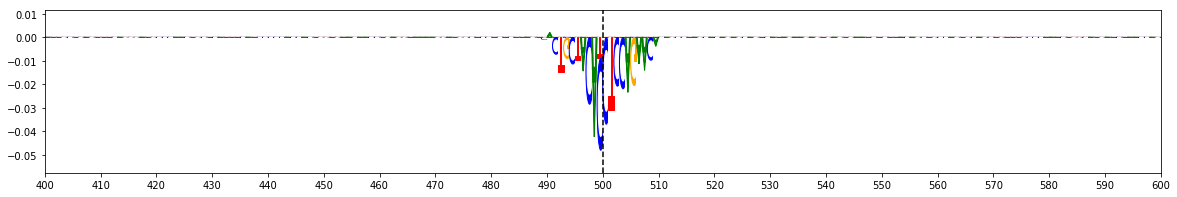


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [8]:
for idx in pos_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', pos_snps.at[idx, 'rsid'],
          '  ||   ', pos_snps.at[idx, 'chr'], ':', pos_snps.at[idx, 'start'], '-', pos_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', pos_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in pos_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
        
    print("Coloc: ", pos_snps.at[idx, 'coloc'])
    
    print()
    
    print('Effect Allele:', pos_snps.at[idx, 'effect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'effect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence:', effect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Noneffect Allele:', pos_snps.at[idx, 'noneffect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'noneffect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence:', noneffect_seqs[idx][490:510])
    
    a = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(pos_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(pos_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(pos_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(pos_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_noneffect_scores[idx] - merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()